In [1]:
import pandas as pd

df = pd.read_pickle("./data/post-processed-metrics-dataframe.pkl")

In [2]:
workflow_regex = r'^([^-]+)'
df["workflow"] = df["dag"].str.extract(workflow_regex)

# Descriptive Statistics

In [3]:
df.columns

Index(['dag', 'system', 'scheduler', 'completed', 'makespan', 'exec_time',
       'run_stats.scheduling_time', 'run_stats.total_task_time',
       'run_stats.total_network_traffic', 'run_stats.total_network_time',
       'run_stats.max_used_cores', 'run_stats.max_used_memory',
       'run_stats.max_cpu_utilization', 'run_stats.max_memory_utilization',
       'run_stats.cpu_utilization', 'run_stats.memory_utilization',
       'run_stats.used_resource_count', 'run_stats.cpu_utilization_used',
       'run_stats.memory_utilization_used', 'run_stats.cpu_utilization_active',
       'run_stats.memory_utilization_active', 'run_stats.expected_makespan',
       'dag_path', 'system_path', 'dag_nodes', 'dag_edges', 'dag_density',
       'speedup', 'processor_count', 'core_count', 'efficiency_processors',
       'efficiency_cores', 'network_bandwidth', 'network_latency',
       'network_model', 'SLR', 'workflow'],
      dtype='object')

In [4]:
cols = ["makespan","exec_time","dag_nodes","dag_edges", "dag_density",
        "speedup", "efficiency_processors", "efficiency_cores", "SLR",
       "scheduler"]
means = df[cols].groupby("scheduler").mean()

Below we see that that, based on the normalized makespan (`SLR`), `HEFT` has the lowest mean `SLR` followed by `DLS`, then `DynamicList`. The "best" `DYTAS` variant based on this alone would be where it navigates all tasks in the current `PTQ`, uses `DFS` for sorting tasks, and uses all available cores in the processor.

Another thing to notices is how simply using `all cores` available minimizes `SLR` in `DYTAS`.

Further analysis required to determine whether `Khan` or `DFS` are better for sorting.

In [5]:
means[["SLR"]].sort_values(by="SLR")

SLR
scheduler                                                     
HEFT                                                172.791493
DLS                                                 172.802363
DynamicList[task=CompSize,resource=Speed,cores=...  174.229101
DYTAS[navigation=All,sorting=DFS,multicore=UseA...  174.603084
DYTAS[navigation=All,sorting=Khan,multicore=Use...  174.659744
DYTAS[navigation=Front,sorting=Khan,multicore=U...  174.721715
DYTAS[navigation=Front,sorting=DFS,multicore=Us...  177.153828
DYTAS[navigation=All,sorting=DFS,multicore=Skip...  179.735548
DYTAS[navigation=All,sorting=Khan,multicore=Ski...  179.784896
DYTAS[navigation=Front,sorting=Khan,multicore=S...  179.821060
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...  181.816478

Below we see, with the `makespan`, the same results as before, which suggests that the way `SLR` is being calculated accurately.

In [6]:
means[["makespan"]].sort_values(by="makespan")

makespan
scheduler                                                       
HEFT                                                30140.958109
DLS                                                 30146.289865
DynamicList[task=CompSize,resource=Speed,cores=...  30185.946040
DYTAS[navigation=All,sorting=DFS,multicore=UseA...  30282.909871
DYTAS[navigation=All,sorting=Khan,multicore=Use...  30306.967385
DYTAS[navigation=Front,sorting=Khan,multicore=U...  30328.326716
DYTAS[navigation=Front,sorting=DFS,multicore=Us...  30760.297794
DYTAS[navigation=All,sorting=DFS,multicore=Skip...  31953.963560
DYTAS[navigation=All,sorting=Khan,multicore=Ski...  32011.552303
DYTAS[navigation=Front,sorting=Khan,multicore=S...  32027.000837
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...  32355.541603

In terms of how long the algorithm took to converge to a final solution, the pattern changes. All `DYTAS` variants end up taking, on average, less time than all the other schedulers, `DLS` taking 50 times longer than `HEFT` and 388 times longer than the fastest algorithm on average.

Important to note, this is just the execution time of the algorithm. It does not represent makespan performance.

In [7]:
means[["exec_time"]].sort_values(by="exec_time")

exec_time
scheduler                                                    
DYTAS[navigation=Front,sorting=Khan,multicore=U...   0.014595
DYTAS[navigation=All,sorting=Khan,multicore=Use...   0.016482
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...   0.023460
DYTAS[navigation=Front,sorting=DFS,multicore=Us...   0.024084
DYTAS[navigation=All,sorting=DFS,multicore=Skip...   0.024502
DYTAS[navigation=Front,sorting=Khan,multicore=S...   0.025355
DYTAS[navigation=All,sorting=Khan,multicore=Ski...   0.026249
DYTAS[navigation=All,sorting=DFS,multicore=UseA...   0.026281
HEFT                                                 0.035404
DynamicList[task=CompSize,resource=Speed,cores=...   0.111311
DLS                                                  5.665025

In [8]:
5.665025 / 0.111311

50.89366729254072

In [9]:
5.665025 / 0.014595

388.14833847207944

Below we see that `HEFT`, quickly followed by `DLS`, achieve -on average- the best speedups w.r.t. all other algorithms. All `DYTAS` variants end up in last place, but we see a similar pattern to the mean `SLR` per algorithm in terms of hierarchy: navigating all tasks, using `DFS` for sorting, als using all available cores achieved the largest speedup in comparison to the rest of the `DYTAS` variants.

Further analysis is required to determine whether `Khan` or `DFS` are best sorting methods.

In [10]:
means[["speedup"]].sort_values(by="speedup", ascending=False)

speedup
scheduler                                                    
HEFT                                                19.406663
DLS                                                 19.355288
DynamicList[task=CompSize,resource=Speed,cores=...  17.279120
DYTAS[navigation=All,sorting=DFS,multicore=UseA...  16.041361
DYTAS[navigation=All,sorting=Khan,multicore=Use...  15.855145
DYTAS[navigation=Front,sorting=Khan,multicore=U...  15.104203
DYTAS[navigation=Front,sorting=DFS,multicore=Us...  10.672198
DYTAS[navigation=All,sorting=DFS,multicore=Skip...   5.824928
DYTAS[navigation=All,sorting=Khan,multicore=Ski...   5.810751
DYTAS[navigation=Front,sorting=Khan,multicore=S...   5.760099
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...   4.959547

Below we see a similar pattern to before. `HEFT`, on average, has the best cores efficiency out of all. All `DYTAS` variants are last.

In [11]:
means[["efficiency_cores"]].sort_values(by="efficiency_cores", ascending=False)

efficiency_cores
scheduler                                                           
HEFT                                                        0.437060
DLS                                                         0.435635
DynamicList[task=CompSize,resource=Speed,cores=...          0.403103
DYTAS[navigation=All,sorting=DFS,multicore=UseA...          0.382910
DYTAS[navigation=All,sorting=Khan,multicore=Use...          0.379793
DYTAS[navigation=Front,sorting=Khan,multicore=U...          0.369700
DYTAS[navigation=Front,sorting=DFS,multicore=Us...          0.298138
DYTAS[navigation=All,sorting=DFS,multicore=Skip...          0.256883
DYTAS[navigation=All,sorting=Khan,multicore=Ski...          0.255937
DYTAS[navigation=Front,sorting=Khan,multicore=S...          0.254166
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...          0.224954

Here we see the same as before, and we see a stronger dip in efficiency when `DYTAS` does not use all cores available.

In [12]:
means[["efficiency_processors"]].sort_values(by="efficiency_processors", ascending=False)

efficiency_processors
scheduler                                                                
HEFT                                                             2.510757
DLS                                                              2.505892
DynamicList[task=CompSize,resource=Speed,cores=...               2.249316
DYTAS[navigation=All,sorting=DFS,multicore=UseA...               2.102322
DYTAS[navigation=All,sorting=Khan,multicore=Use...               2.077707
DYTAS[navigation=Front,sorting=Khan,multicore=U...               1.969350
DYTAS[navigation=Front,sorting=DFS,multicore=Us...               1.397696
DYTAS[navigation=All,sorting=DFS,multicore=Skip...               0.668725
DYTAS[navigation=All,sorting=Khan,multicore=Ski...               0.667665
DYTAS[navigation=Front,sorting=Khan,multicore=S...               0.663166
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...               0.583660

In [13]:
medians = df[cols].groupby("scheduler").median()

In [14]:
medians[["SLR"]].sort_values(by="SLR")

SLR
scheduler                                                   
HEFT                                                1.447366
DLS                                                 1.454858
DynamicList[task=CompSize,resource=Speed,cores=...  1.694747
DYTAS[navigation=All,sorting=DFS,multicore=UseA...  1.971757
DYTAS[navigation=All,sorting=Khan,multicore=Use...  2.013060
DYTAS[navigation=Front,sorting=Khan,multicore=U...  2.130201
DYTAS[navigation=Front,sorting=DFS,multicore=Us...  3.124691
DYTAS[navigation=All,sorting=DFS,multicore=Skip...  5.124313
DYTAS[navigation=All,sorting=Khan,multicore=Ski...  5.125658
DYTAS[navigation=Front,sorting=Khan,multicore=S...  5.161273
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...  5.941372

In terms of medians, we see here an edge from a `DYTAS` variant w.r.t. `DynamicList`.

In [15]:
medians[["makespan"]].sort_values(by="makespan")

makespan
scheduler                                                      
HEFT                                                 396.729215
DLS                                                  396.732309
DYTAS[navigation=All,sorting=DFS,multicore=UseA...   436.613850
DynamicList[task=CompSize,resource=Speed,cores=...   442.874830
DYTAS[navigation=All,sorting=Khan,multicore=Use...   454.810668
DYTAS[navigation=Front,sorting=Khan,multicore=U...   471.047007
DYTAS[navigation=Front,sorting=DFS,multicore=Us...   766.527884
DYTAS[navigation=All,sorting=Khan,multicore=Ski...  1016.444779
DYTAS[navigation=All,sorting=DFS,multicore=Skip...  1018.415053
DYTAS[navigation=Front,sorting=Khan,multicore=S...  1030.395115
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...  1237.369779

In [16]:
medians[["exec_time"]].sort_values(by="exec_time")

exec_time
scheduler                                                    
DYTAS[navigation=All,sorting=Khan,multicore=Use...   0.007887
DYTAS[navigation=Front,sorting=Khan,multicore=U...   0.007894
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...   0.008129
DYTAS[navigation=Front,sorting=DFS,multicore=Us...   0.008462
DYTAS[navigation=Front,sorting=Khan,multicore=S...   0.008700
DYTAS[navigation=All,sorting=DFS,multicore=UseA...   0.008799
DYTAS[navigation=All,sorting=Khan,multicore=Ski...   0.008841
DYTAS[navigation=All,sorting=DFS,multicore=Skip...   0.008961
HEFT                                                 0.013287
DynamicList[task=CompSize,resource=Speed,cores=...   0.025836
DLS                                                  0.421648

In [17]:
medians[["speedup"]].sort_values(by="speedup", ascending=False)

speedup
scheduler                                                    
HEFT                                                11.911275
DLS                                                 11.911275
DynamicList[task=CompSize,resource=Speed,cores=...  11.119757
DYTAS[navigation=All,sorting=DFS,multicore=UseA...  10.322029
DYTAS[navigation=All,sorting=Khan,multicore=Use...  10.056317
DYTAS[navigation=Front,sorting=Khan,multicore=U...   9.931890
DYTAS[navigation=Front,sorting=DFS,multicore=Us...   7.043853
DYTAS[navigation=All,sorting=DFS,multicore=Skip...   4.565832
DYTAS[navigation=All,sorting=Khan,multicore=Ski...   4.535916
DYTAS[navigation=Front,sorting=Khan,multicore=S...   4.461125
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...   3.923717

In [18]:
medians[["efficiency_cores"]].sort_values(by="efficiency_cores", ascending=False)

efficiency_cores
scheduler                                                           
DLS                                                         0.407135
HEFT                                                        0.406756
DynamicList[task=CompSize,resource=Speed,cores=...          0.346001
DYTAS[navigation=All,sorting=DFS,multicore=UseA...          0.318270
DYTAS[navigation=All,sorting=Khan,multicore=Use...          0.313928
DYTAS[navigation=Front,sorting=Khan,multicore=U...          0.297747
DYTAS[navigation=Front,sorting=DFS,multicore=Us...          0.187085
DYTAS[navigation=All,sorting=DFS,multicore=Skip...          0.084401
DYTAS[navigation=All,sorting=Khan,multicore=Ski...          0.084260
DYTAS[navigation=Front,sorting=Khan,multicore=S...          0.083489
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...          0.075537

In [19]:
medians[["efficiency_processors"]].sort_values(by="efficiency_processors", ascending=False)

efficiency_processors
scheduler                                                                
DLS                                                              1.085090
HEFT                                                             1.085090
DynamicList[task=CompSize,resource=Speed,cores=...               1.039581
DYTAS[navigation=All,sorting=Khan,multicore=Use...               0.989582
DYTAS[navigation=All,sorting=DFS,multicore=UseA...               0.988343
DYTAS[navigation=Front,sorting=Khan,multicore=U...               0.983092
DYTAS[navigation=Front,sorting=DFS,multicore=Us...               0.803130
DYTAS[navigation=All,sorting=DFS,multicore=Skip...               0.674651
DYTAS[navigation=All,sorting=Khan,multicore=Ski...               0.672391
DYTAS[navigation=Front,sorting=Khan,multicore=S...               0.666696
DYTAS[navigation=Front,sorting=DFS,multicore=Sk...               0.605308

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [21]:
df["SLR"].min()

1.0000000037317578

In [22]:
df["SLR"].max()

94277.09025707922

In [23]:
df["SLR"].median()

2.827247893927927

In [24]:
df["SLR"].mean()

176.55630084386564

## Distributions

Conclusion: Data is not normally distributed. Seems heavily skewed on most cases.

<Axes: xlabel='makespan'>

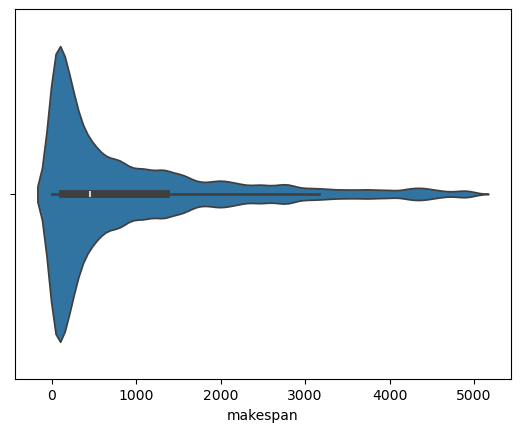

In [25]:
sns.violinplot(data=df[(df["makespan"] < 5000)], x="makespan")

<Axes: xlabel='makespan'>

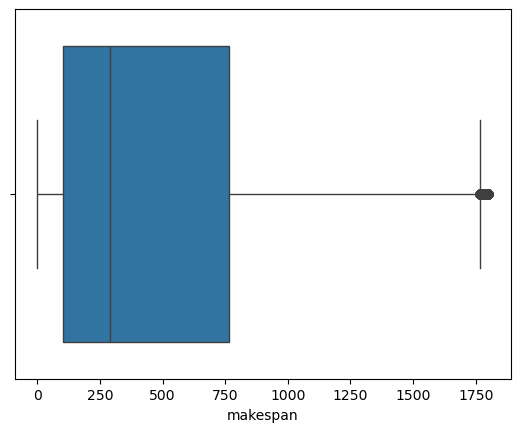

In [26]:
sns.boxplot(data=df[(df["makespan"] < 1800)], x="makespan")

<Axes: xlabel='SLR'>

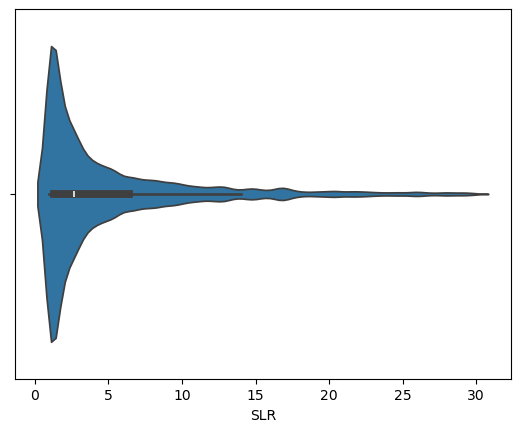

In [27]:
sns.violinplot(data=df[(df["SLR"] < 30)], x="SLR")

<Axes: xlabel='exec_time'>

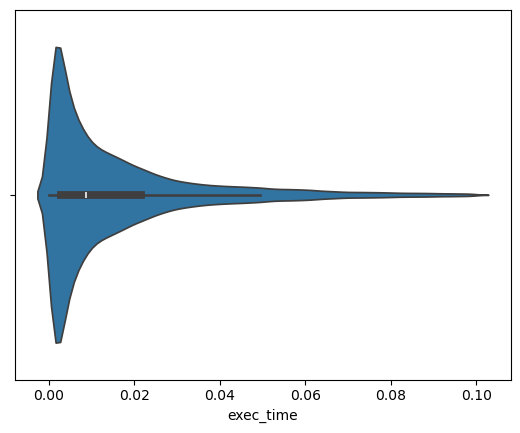

In [28]:
sns.violinplot(data=df[df["exec_time"] < .1], x="exec_time")

<Axes: xlabel='speedup'>

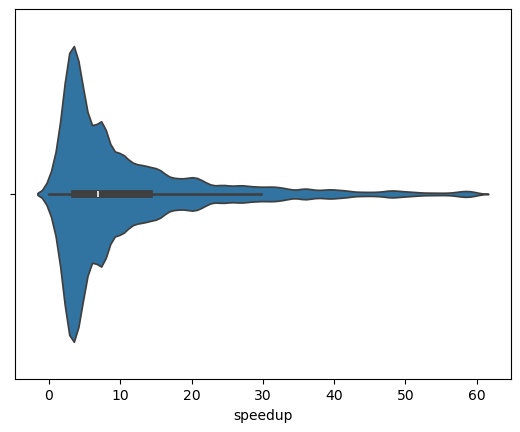

In [29]:
sns.violinplot(data=df[df["speedup"] < 60], x="speedup")

<Axes: xlabel='efficiency_processors'>

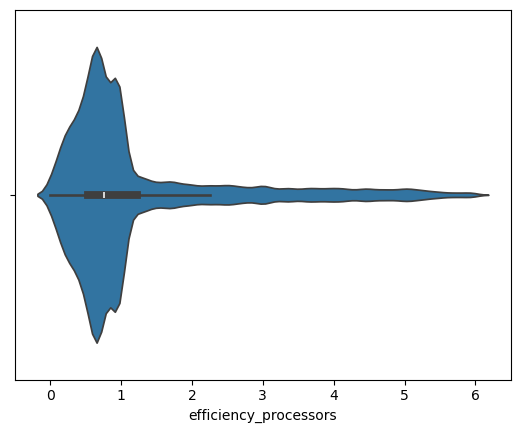

In [30]:
sns.violinplot(data=df[df["efficiency_processors"] < 6], x="efficiency_processors")

<Axes: xlabel='efficiency_cores'>

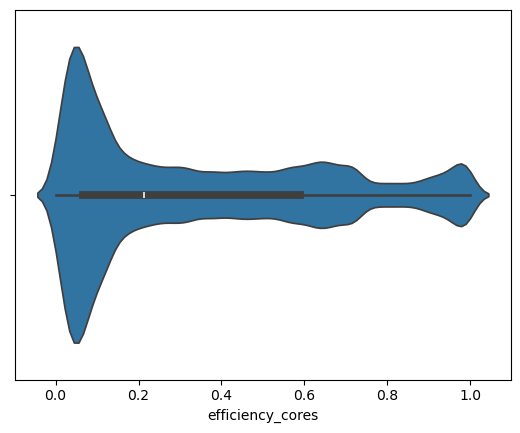

In [31]:
sns.violinplot(data=df, x="efficiency_cores")

<Axes: xlabel='dag_edges'>

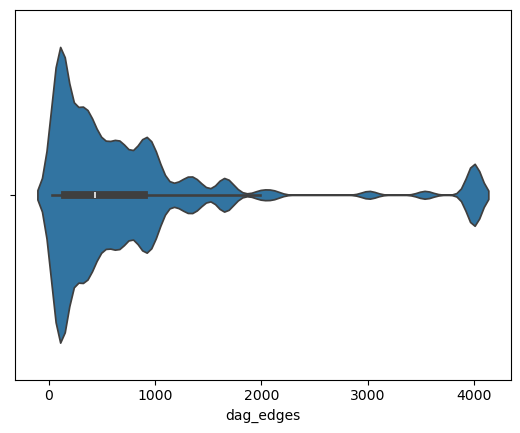

In [32]:
sns.violinplot(data=df, x="dag_edges")

<Axes: xlabel='dag_nodes'>

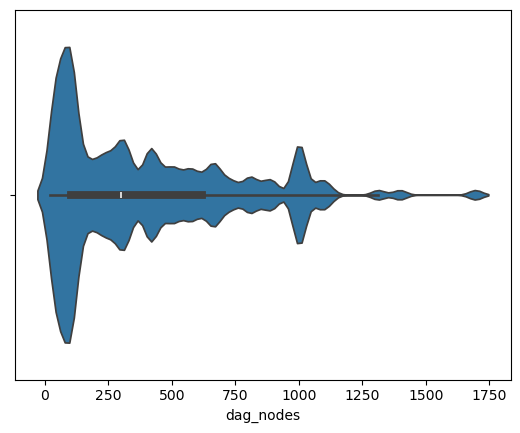

In [33]:
sns.violinplot(data=df, x="dag_nodes")

<Axes: xlabel='dag_density'>

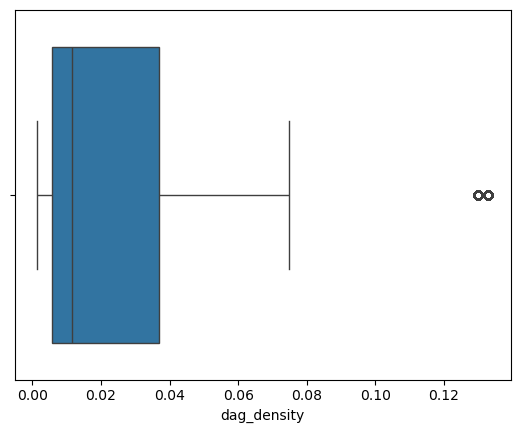

In [34]:
sns.boxplot(data=df, x="dag_density")

<Axes: xlabel='dag_density'>

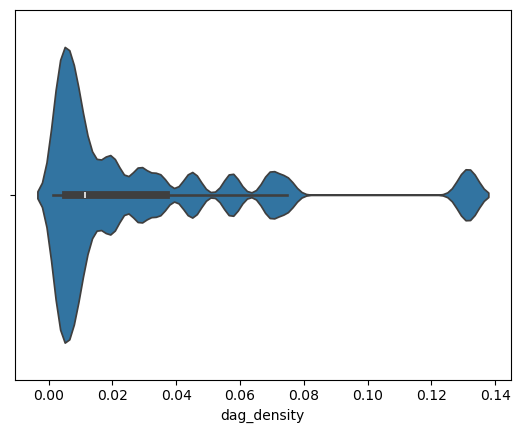

In [35]:
sns.violinplot(data=df, x="dag_density")

<Axes: xlabel='dag_density'>

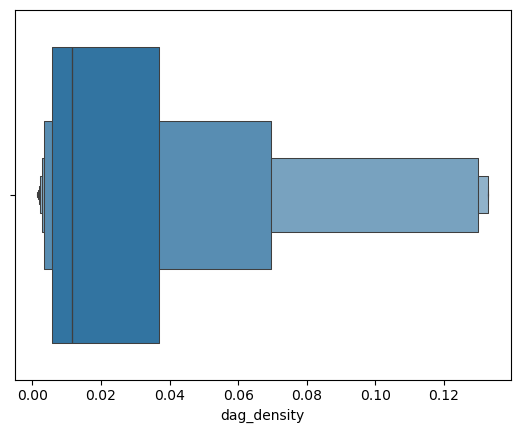

In [36]:
sns.boxenplot(data=df, x="dag_density")

As seen before, the skewness of the data makes it hard to use any normal distribution methods of analysis.

In [37]:
# sns.pairplot(df)

<Axes: xlabel='SLR', ylabel='exec_time'>

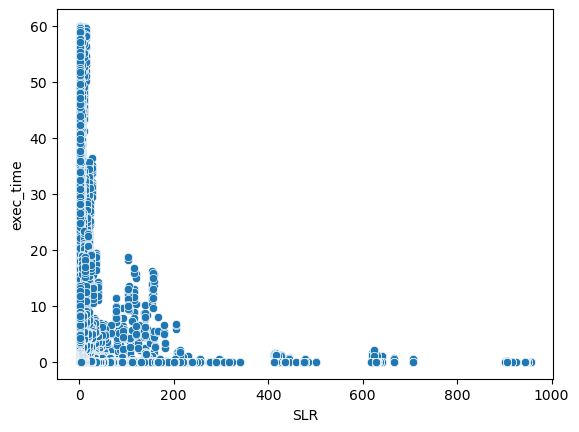

In [38]:
sns.scatterplot(df[(df["SLR"]<1000) & (df["exec_time"] < 60)], x="SLR", y="exec_time")

Below we see that there is not a strong relationship between number of tasks and the SLR, same with number of edges and SLR. This might indicate that some workflow might have less tasks but each task might require more FLOPs to complete than workflows with many tasks.

<Axes: xlabel='dag_nodes', ylabel='SLR'>

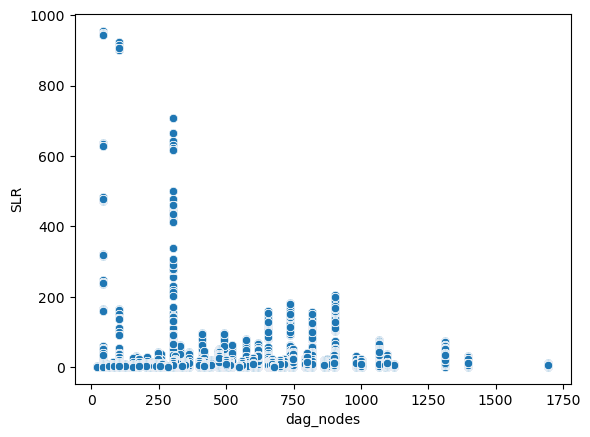

In [39]:
sns.scatterplot(df[(df["SLR"]<1000)], x="dag_nodes", y="SLR")

<Axes: xlabel='dag_edges', ylabel='SLR'>

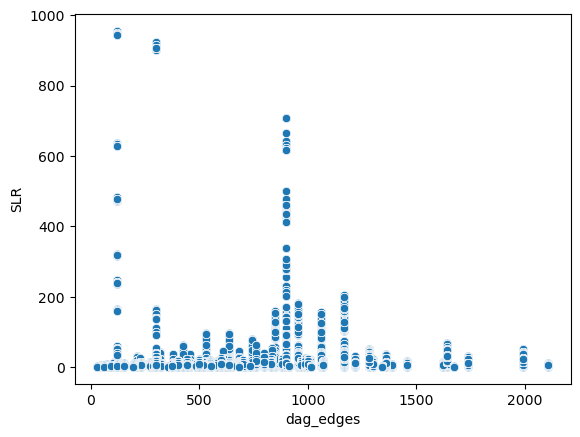

In [40]:
sns.scatterplot(df[(df["SLR"]<1000) & (df["dag_edges"] < 3000)], x="dag_edges", y="SLR")

<Axes: xlabel='SLR'>

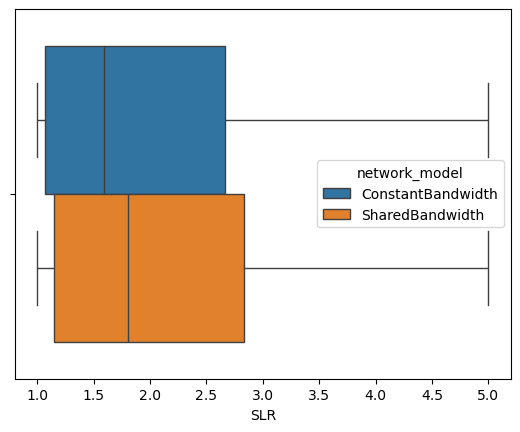

In [49]:
sns.boxplot(data=df[df["SLR"]< 5], x="SLR", hue="network_model")

<Axes: xlabel='makespan'>

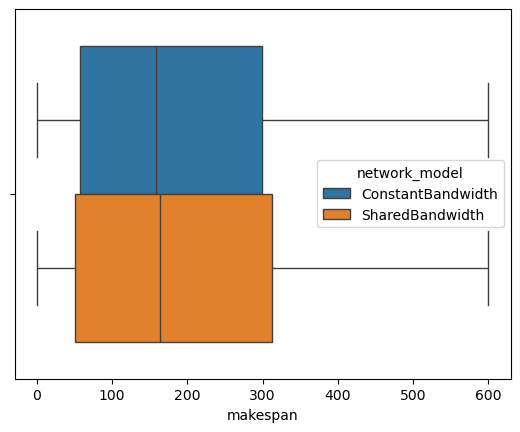

In [52]:
sns.boxplot(data=df[df["makespan"] < 600], x="makespan", hue="network_model")

<Axes: xlabel='SLR'>

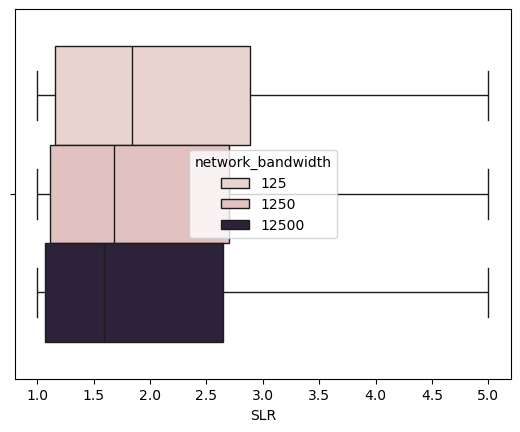

In [53]:
sns.boxplot(data=df[df["SLR"]< 5], x="SLR", hue="network_bandwidth")

<Axes: xlabel='makespan'>

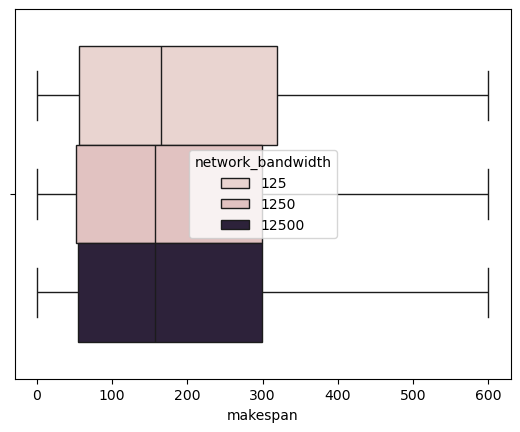

In [54]:
sns.boxplot(data=df[df["makespan"] < 600], x="makespan", hue="network_bandwidth")

<Axes: xlabel='SLR'>

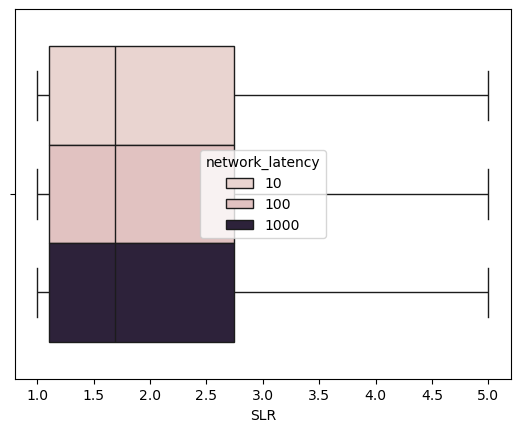

In [57]:
sns.boxplot(data=df[df["SLR"]< 5], x="SLR", hue="network_latency")

<Axes: xlabel='makespan'>

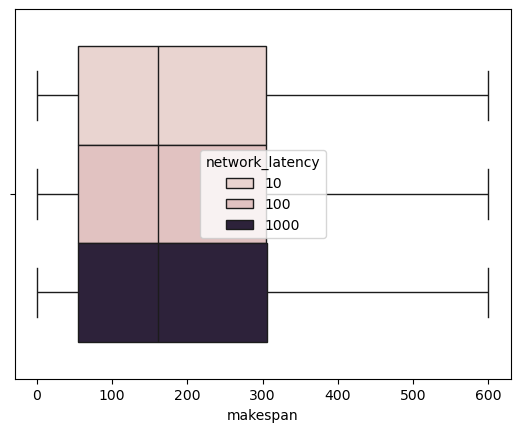

In [58]:
sns.boxplot(data=df[df["makespan"] < 600], x="makespan", hue="network_latency")

Important to note that depending on the workflow and the number of tasks in the DAG, the algorithms will represent varying behaviors that will be hard to plot smoothly.

<Axes: xlabel='workflow', ylabel='dag_nodes'>

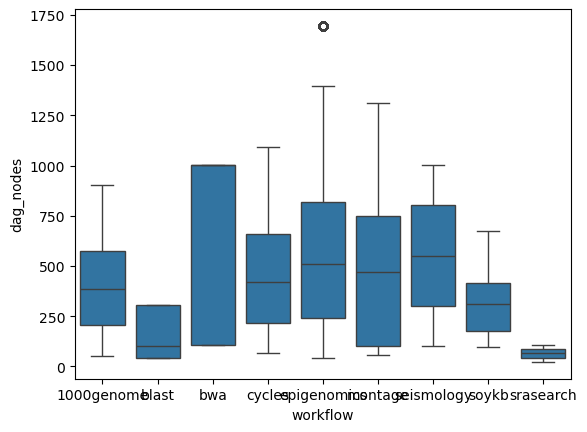

In [116]:
sns.boxplot(df, x="workflow", y="dag_nodes")

In [74]:
# df.columns

# Plotting efficiency per algorithm

The below efficiency figures suggest that the `DYTAS` variants that skip active processors have terrible efficiency compared to the rest.

Out of the `DYTAS` variants, the one with the best efficiency consistently is the one using `navigation=All, sorting=DFS, multicore=UseAllCores` followed by the one using `sorting=Khan`. Nonetheless, none of them reaches even the worst performing scheduler -in terms of efficiency- from the control group (`DynamicList`).

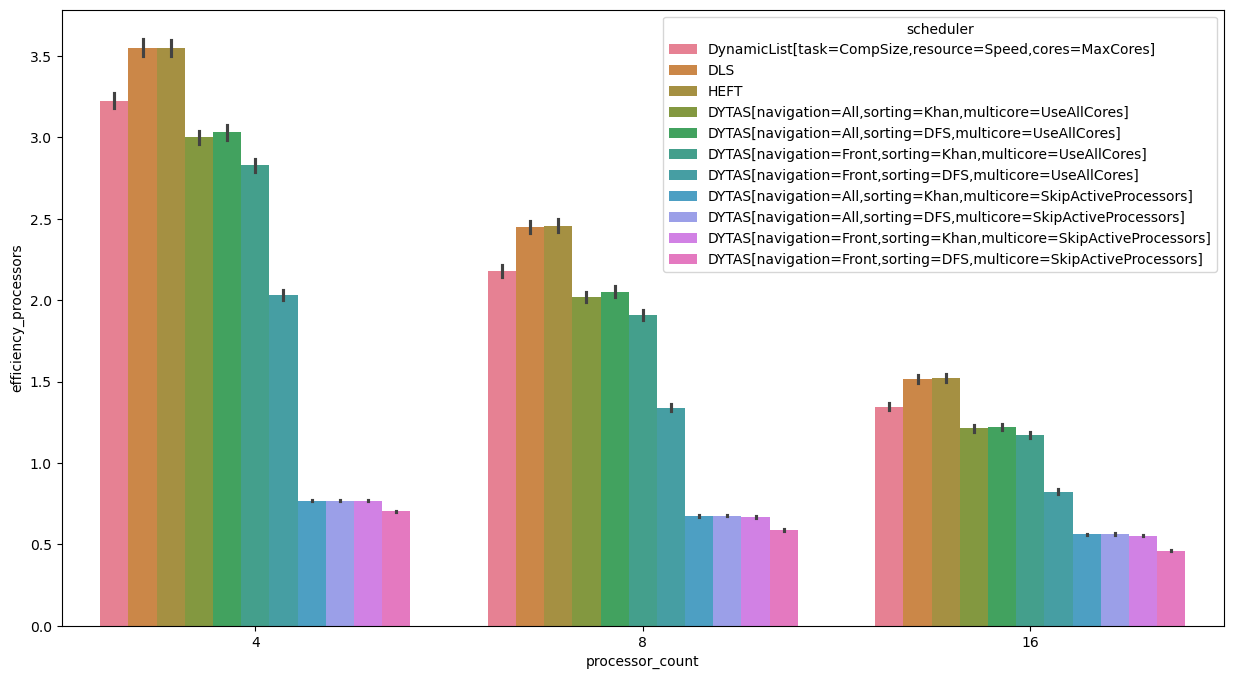

In [75]:


plt.figure(figsize=(15,8))
sns.barplot(data=df, x="processor_count", y="efficiency_processors", hue="scheduler")

plt.show()

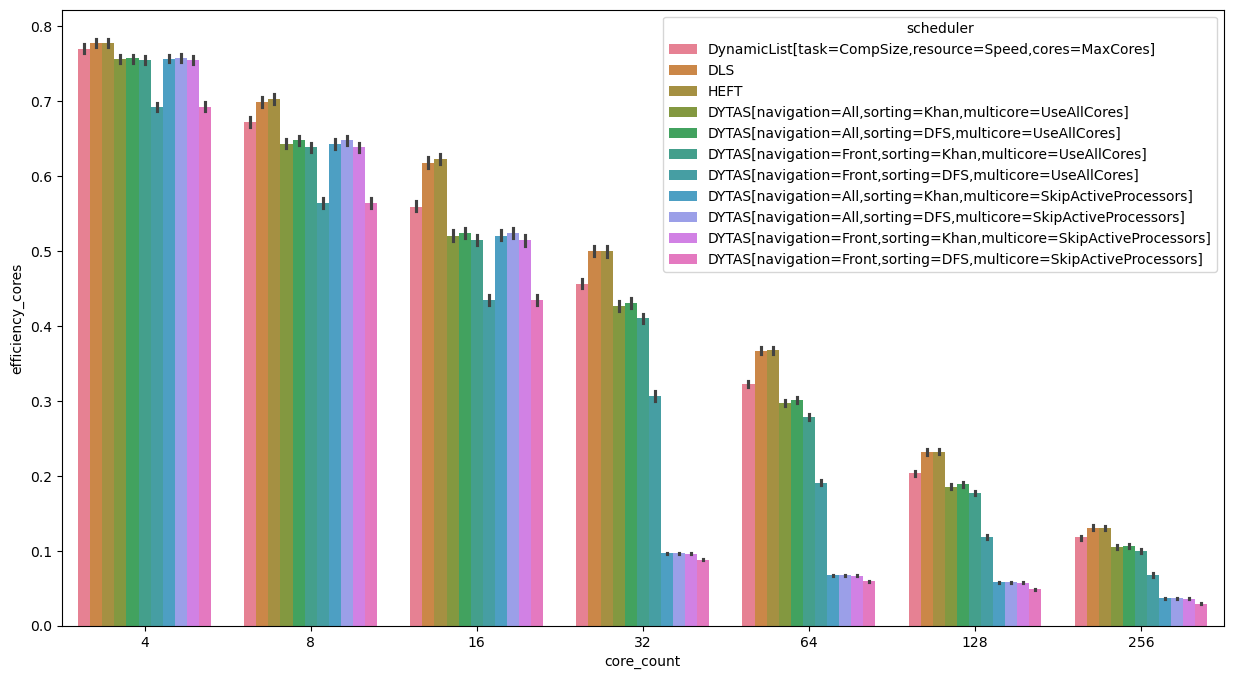

In [71]:
plt.figure(figsize=(15,8))

sns.barplot(data=df, x="core_count", y="efficiency_cores", hue="scheduler")

plt.show()

# Plotting mean SLR vs DAG node count

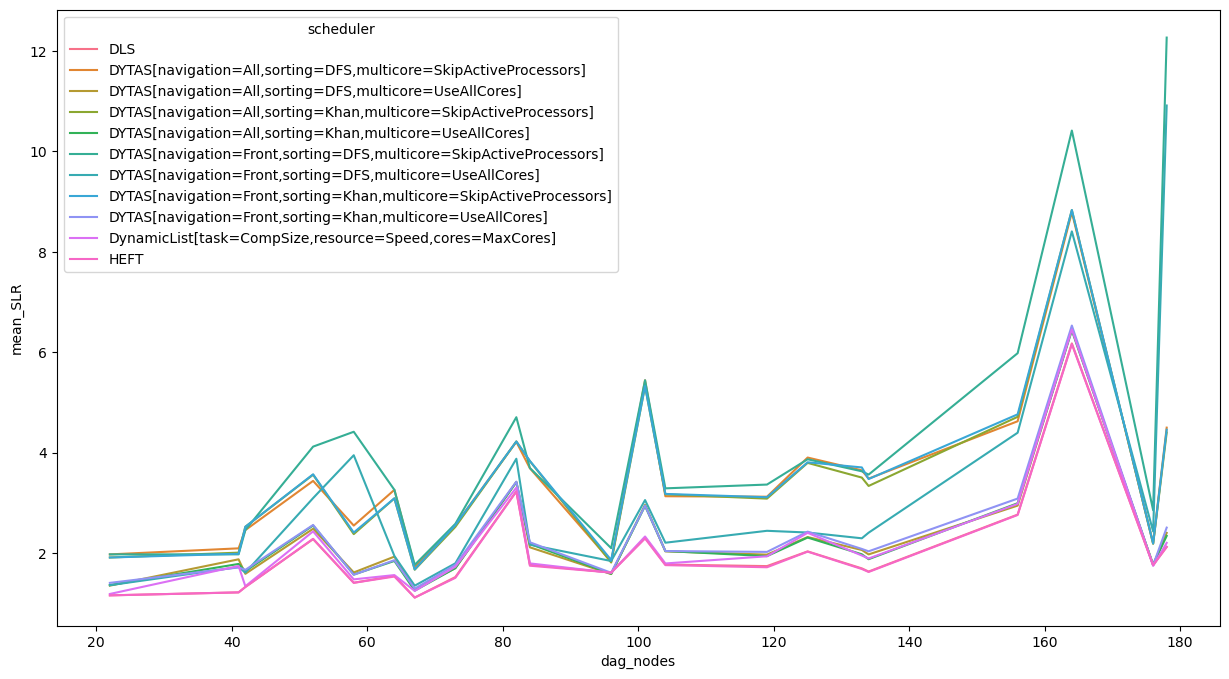

In [118]:
df_mean_slr = df[
    ["SLR", "scheduler", "dag_nodes"]
].groupby(["scheduler", "dag_nodes"]).mean().reset_index()
df_mean_slr = df_mean_slr.rename(columns={"SLR":"mean_SLR"})

plt.figure(figsize=(15,8))

sns.lineplot(
    data=df_mean_slr[
    (df_mean_slr["mean_SLR"]<20) & (df_mean_slr.dag_nodes < 200)],
    y="mean_SLR", x="dag_nodes", hue="scheduler"
)

plt.show()

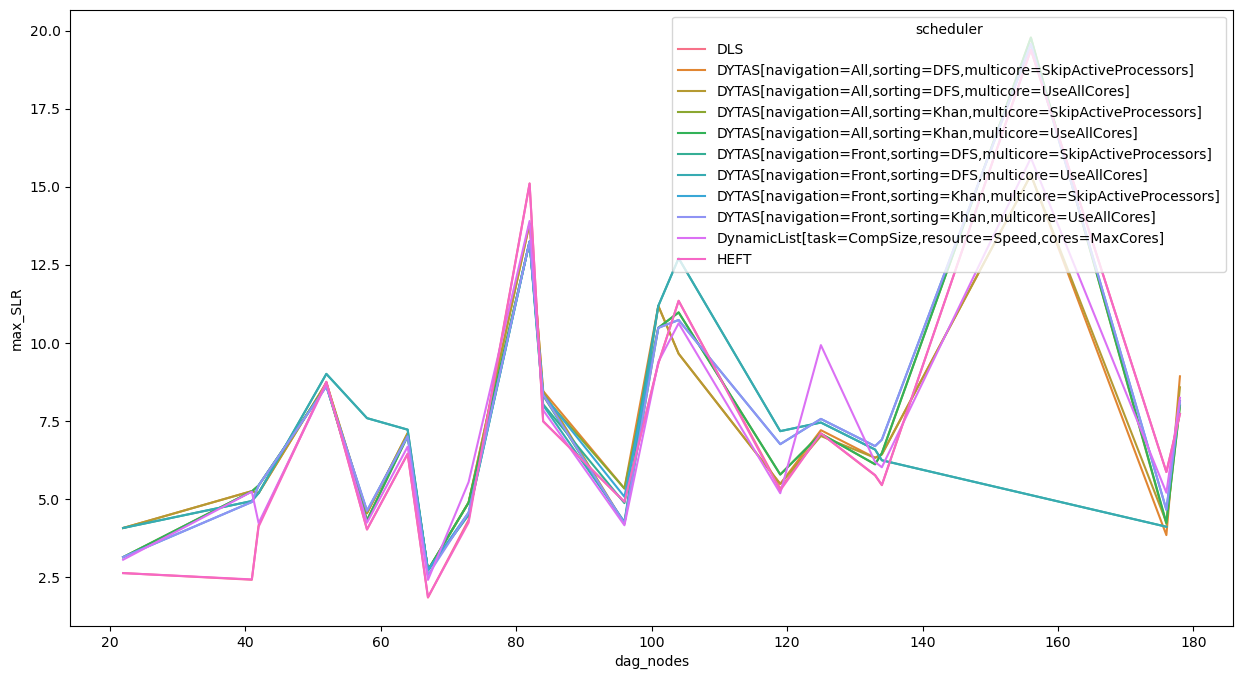

In [114]:
df_max_slr = df[
    ["SLR", "scheduler", "dag_nodes"]
].groupby(["scheduler", "dag_nodes"]).max().reset_index()
df_max_slr = df_max_slr.rename(columns={"SLR":"max_SLR"})

plt.figure(figsize=(15,8))

sns.lineplot(
    data=df_max_slr[
    (df_max_slr["max_SLR"]<20) & (df_max_slr.dag_nodes < 200)],
    y="max_SLR", x="dag_nodes", hue="scheduler"
)

plt.show()

In [ ]:
df_mean_exec_time = df[
    ["exec_time", "scheduler", "dag_nodes"]
].groupby(["scheduler", "dag_nodes"]).mean().reset_index()
df_mean_exec_time = df_mean_exec_time.rename(columns={"exec_time":"mean_exec_time"})

plt.figure(figsize=(15,8))

sns.lineplot(data=df_mean_exec_time[df_mean_exec_time.dag_nodes < 100], y="mean_exec_time", x="dag_nodes", hue="scheduler")

plt.show()

In [ ]:
df_mean_speedup = df[
    ["speedup", "scheduler", "dag_nodes"]
].groupby(["scheduler", "dag_nodes"]).mean().reset_index()
df_mean_speedup = df_mean_speedup.rename(columns={"speedup":"mean_speedup"})

plt.figure(figsize=(15,8))

sns.lineplot(data=df_mean_speedup[df_mean_speedup.dag_nodes < 100], y="mean_speedup", x="dag_nodes", hue="scheduler")

plt.show()

In [143]:
df.workflow.unique()

array(['1000genome', 'blast', 'bwa', 'cycles', 'epigenomics', 'montage',
       'seismology', 'soykb', 'srasearch'], dtype=object)

In [152]:
df_epigenomics = df[df.workflow == "epigenomics"]

In [183]:
def plot_mean_slr(df):
    data=df
    data = data[
    ["SLR", "scheduler", "dag_nodes"]
    ].groupby(["scheduler", "dag_nodes"]).mean().reset_index()
    data = data.rename(columns={"SLR":"mean_SLR"})

    # Smoothing out
    data["mean_SLR_smoothed"] = data["mean_SLR"].rolling(window=5, center=True).mean()
    
    plt.figure(figsize=(15,8))

    plt.title("Mean SLR vs DAG node count")
    
    sns.lineplot(
        data=data,
        y="mean_SLR_smoothed", x="dag_nodes", hue="scheduler",
        marker='o'
    )
    
    plt.show()

We can in more detail see below how it each workflow does not scale smoothly up or down, for these test cases in particular.


1000genome


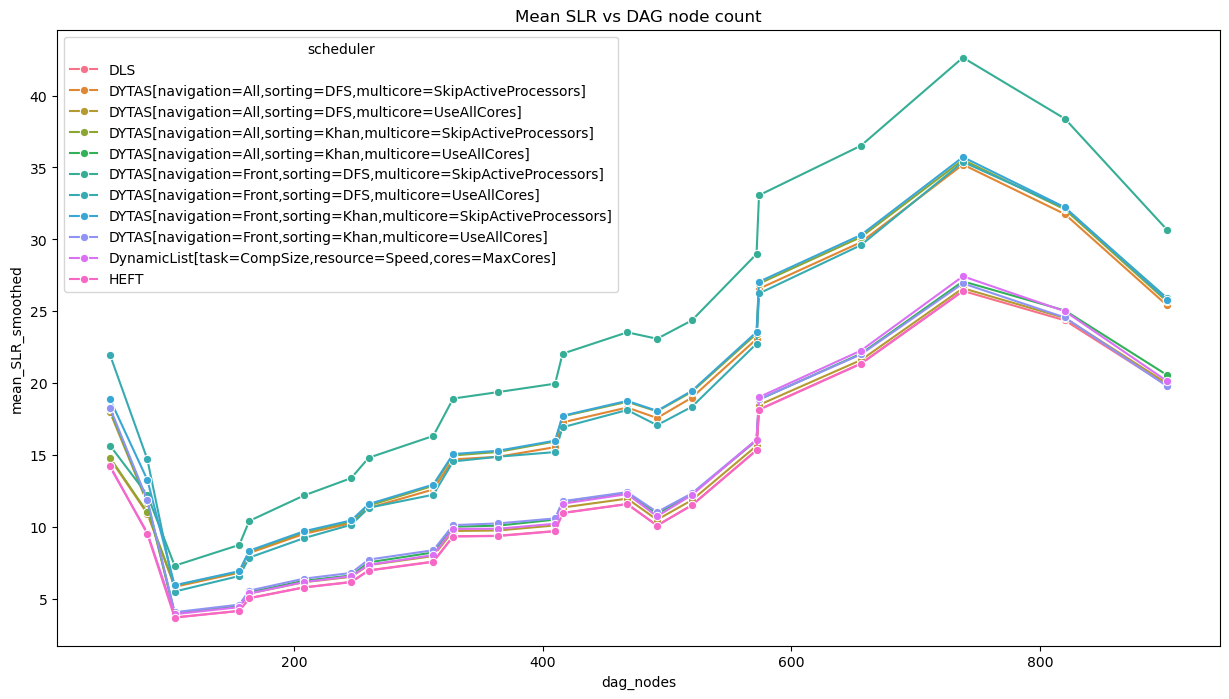

blast


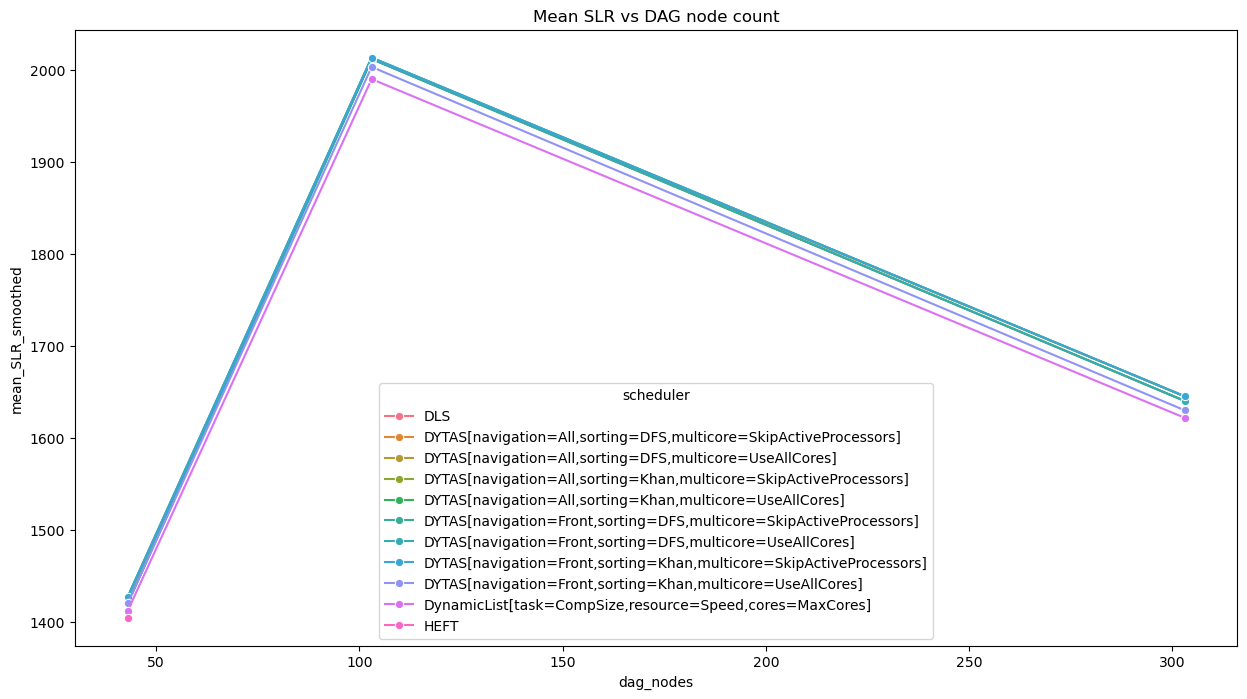

bwa


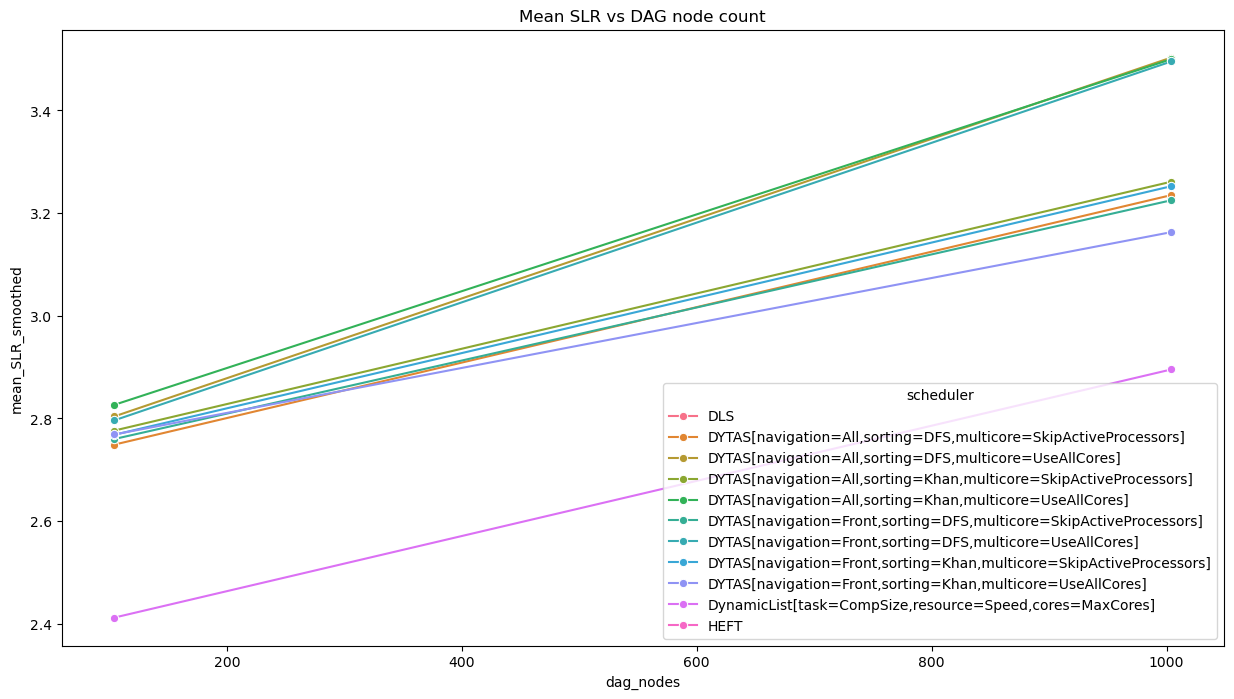

cycles


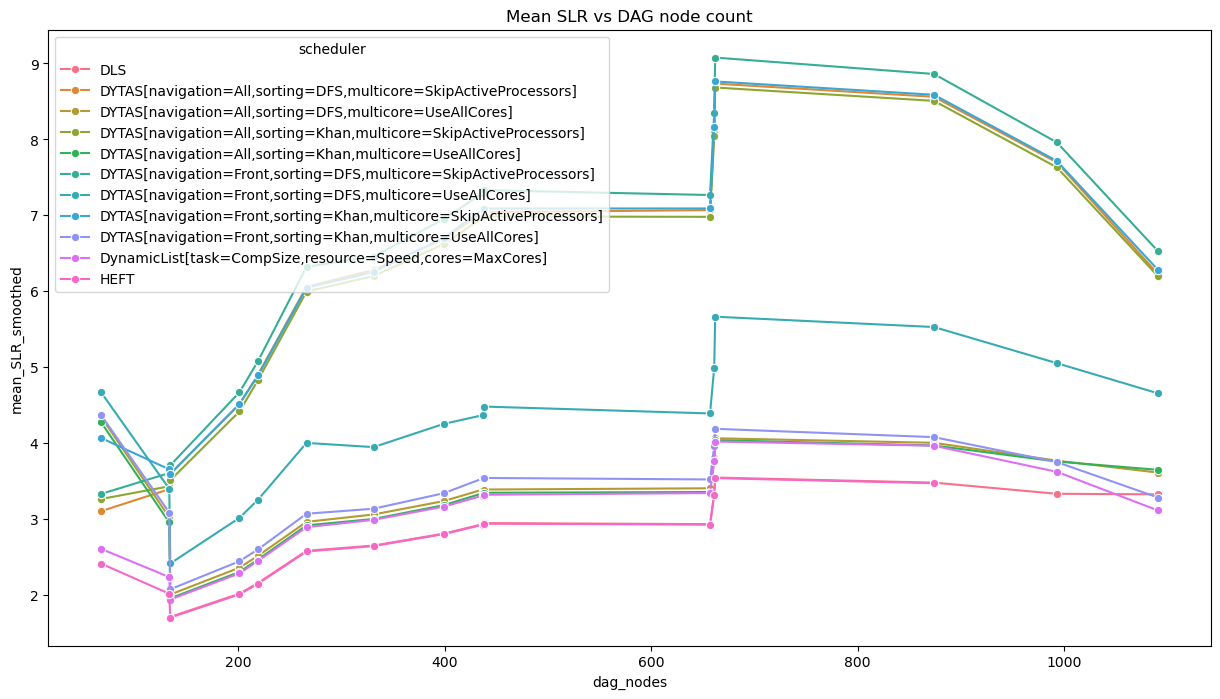

epigenomics


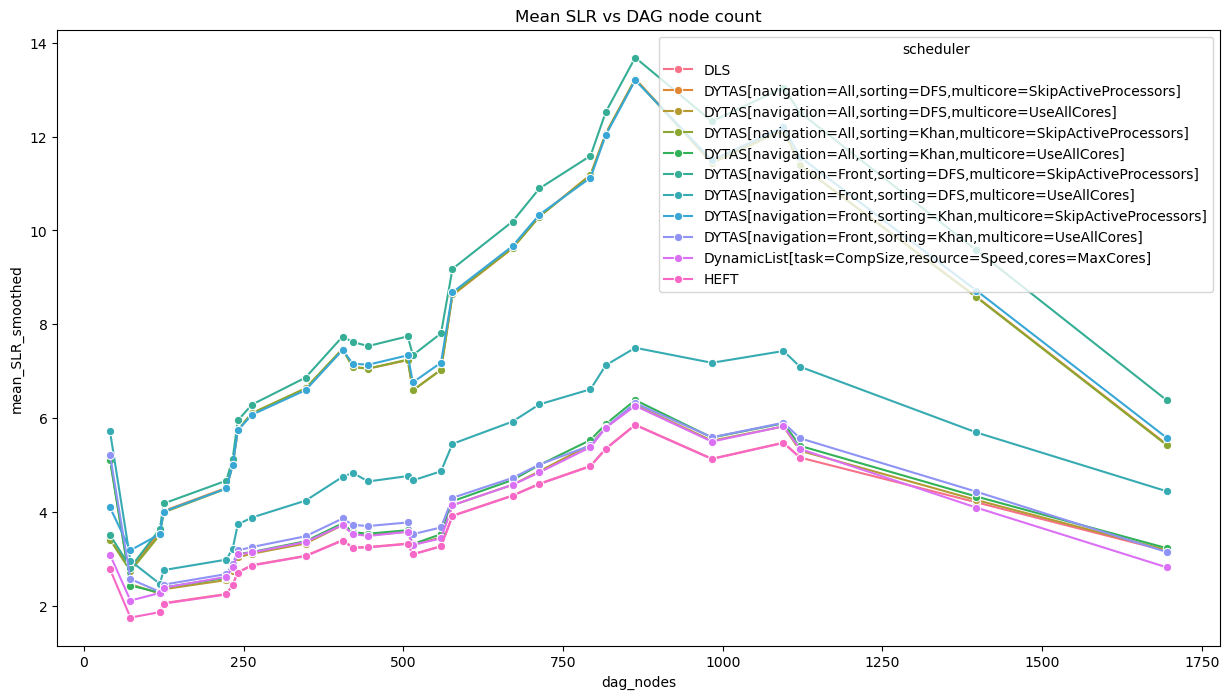

montage


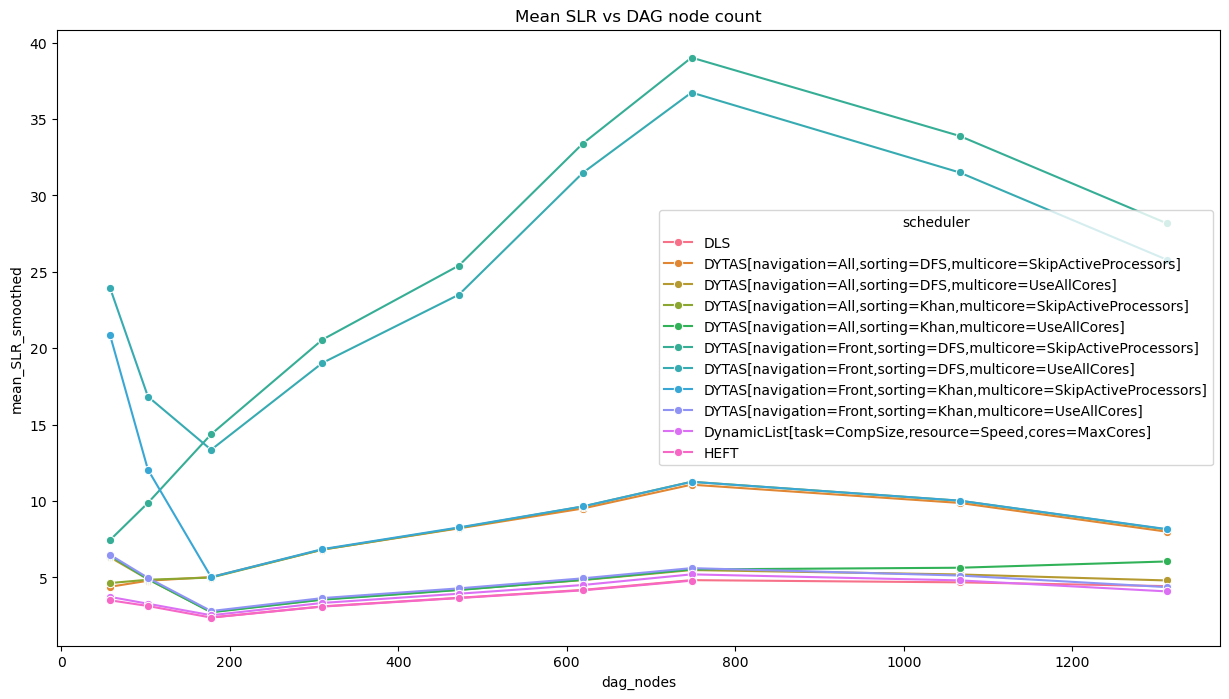

seismology


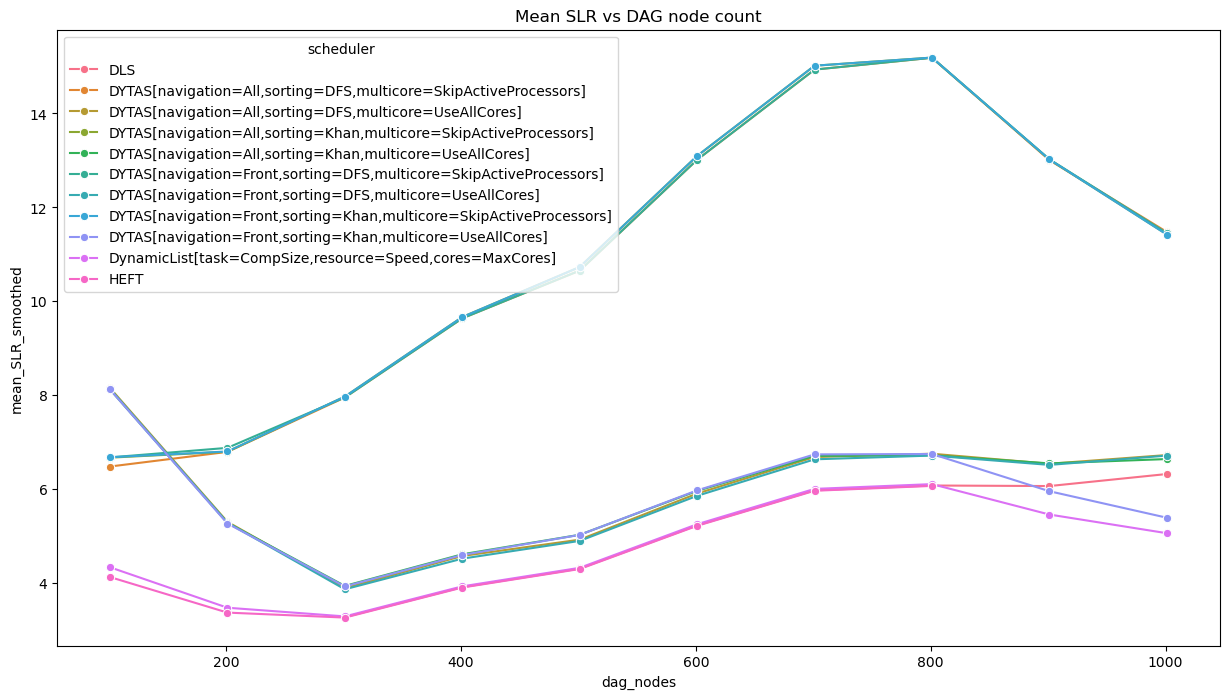

soykb


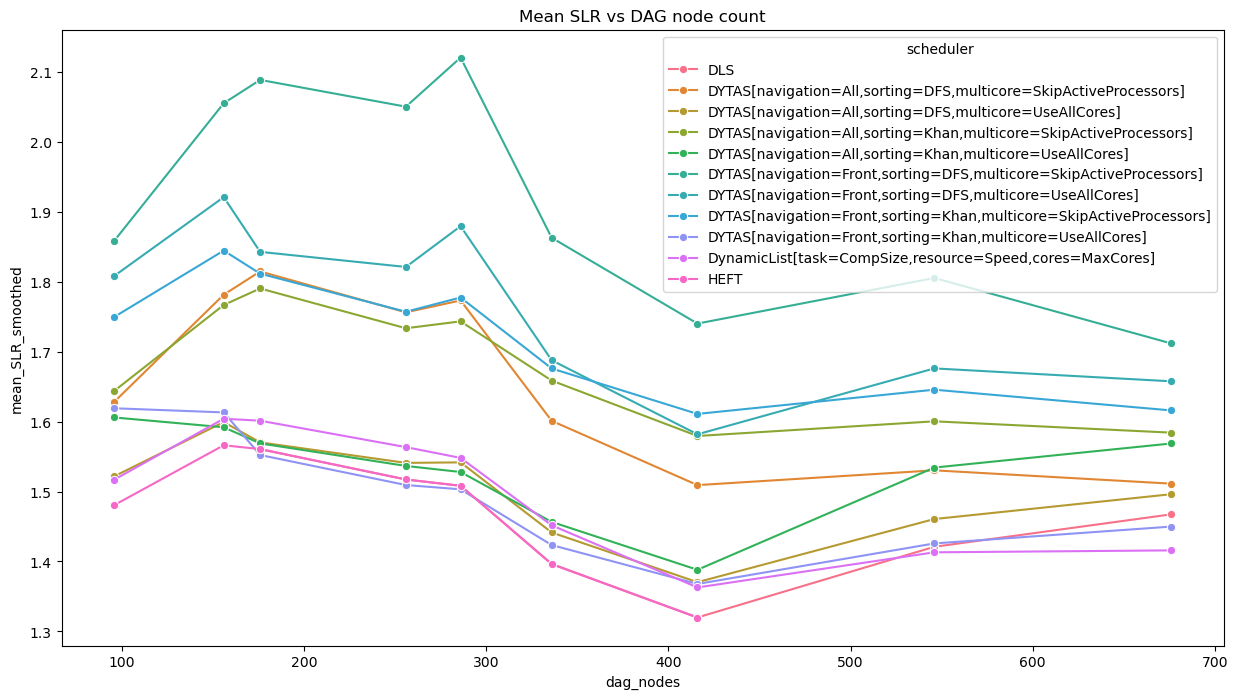

srasearch


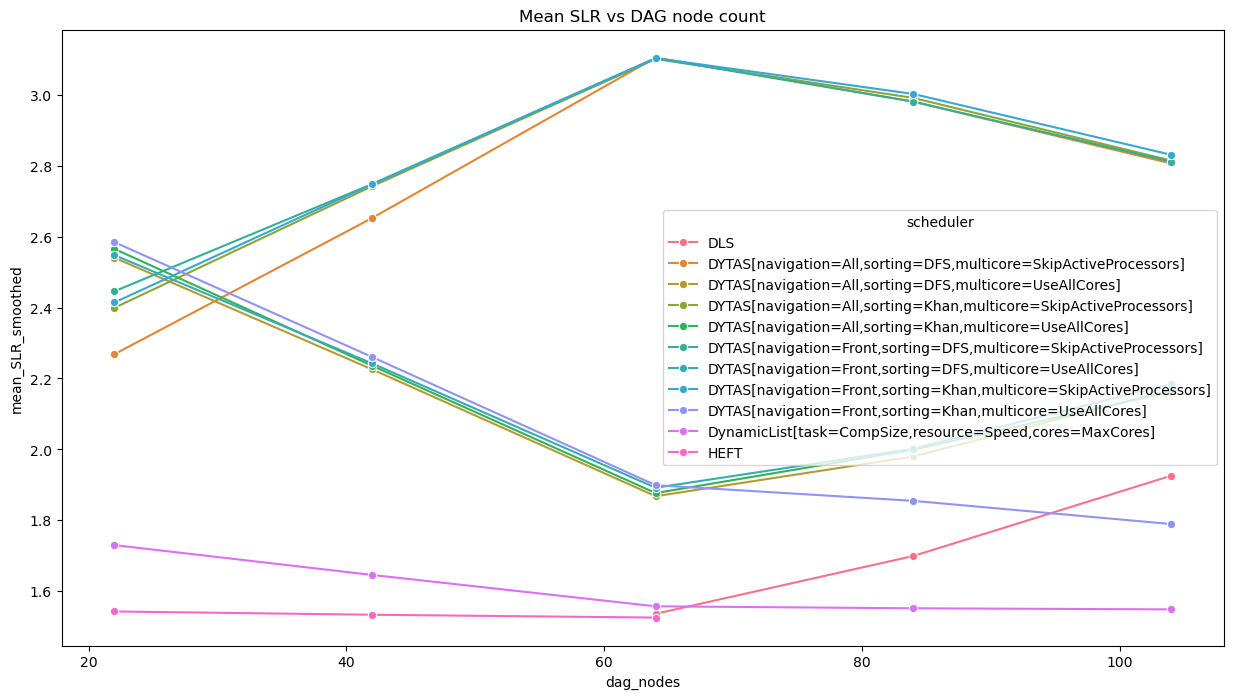

In [186]:
for workflow in df.workflow.unique():
    print(workflow)
    plot_mean_slr(df[df.workflow == workflow])

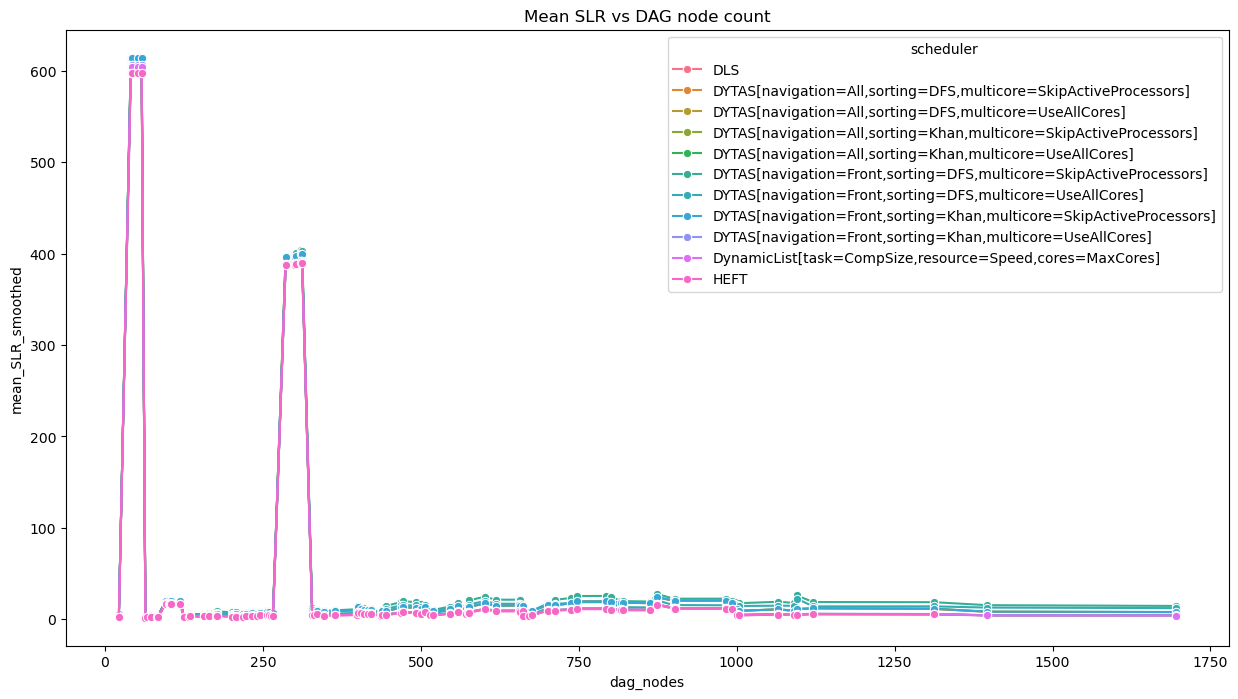

In [185]:
plot_mean_slr(df)

In [188]:
def plot_mean_speedup(df):
    data=df
    data = data[
    ["speedup", "scheduler", "dag_nodes"]
    ].groupby(["scheduler", "dag_nodes"]).mean().reset_index()
    data = data.rename(columns={"speedup":"mean_speedup"})

    # Smoothing out
    # data["mean_SLR_smoothed"] = data["mean_SLR"].rolling(window=5, center=True).mean()
    
    plt.figure(figsize=(15,8))

    plt.title("Mean speedup vs DAG node count")
    
    sns.lineplot(
        data=data,
        y="mean_speedup", x="dag_nodes", hue="scheduler",
        marker='o'
    )
    
    plt.show()

1000genome


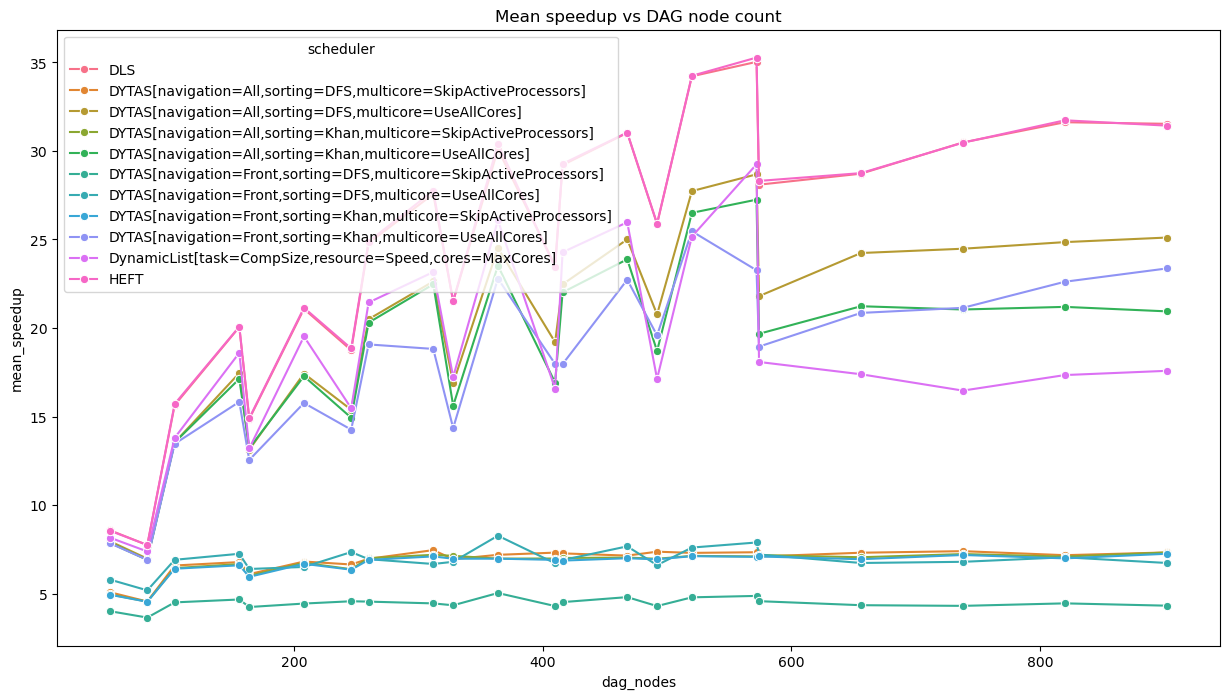

blast


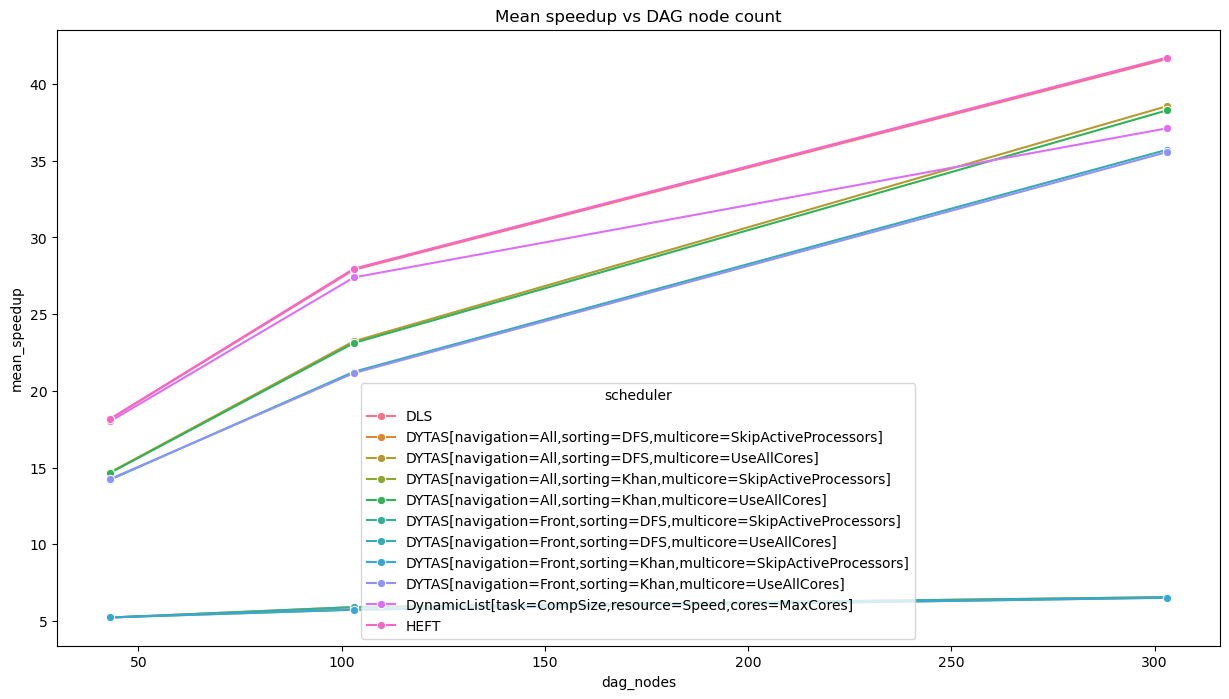

bwa


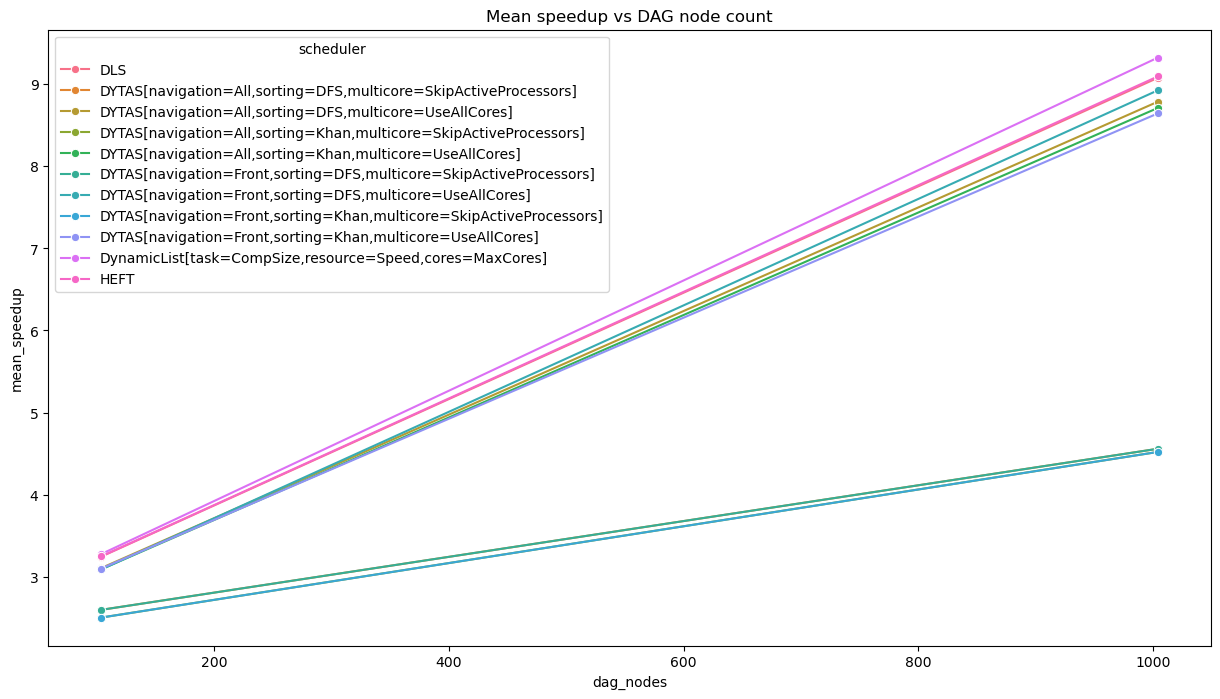

cycles


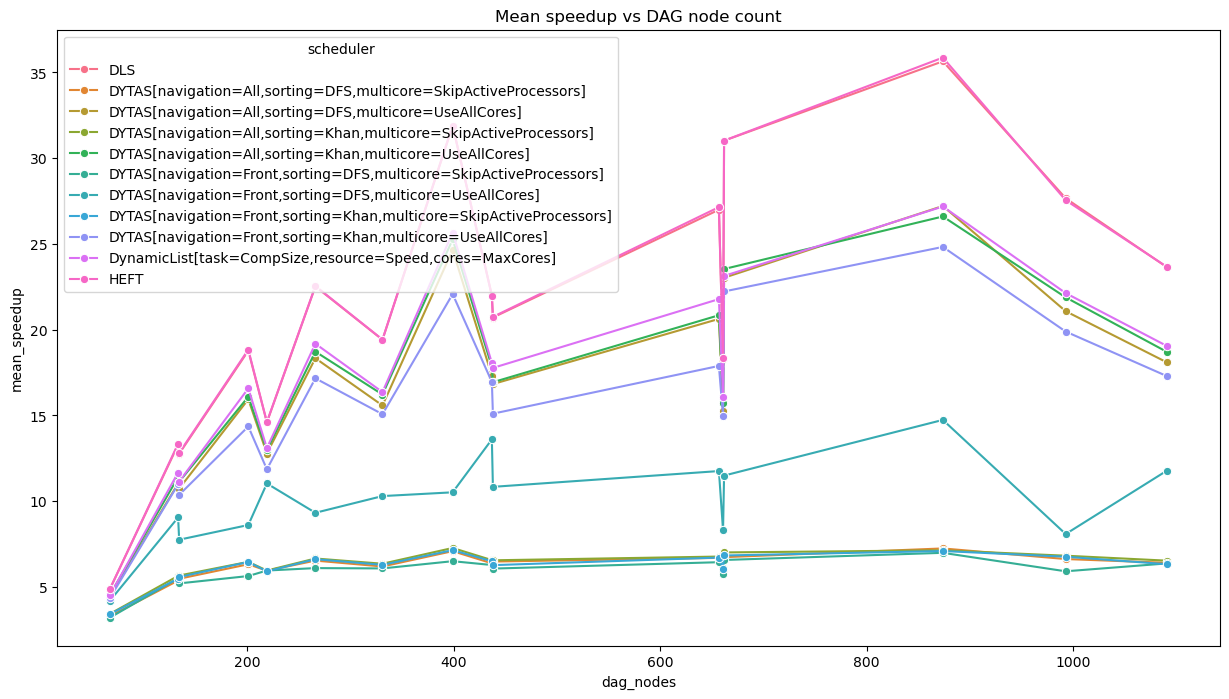

epigenomics


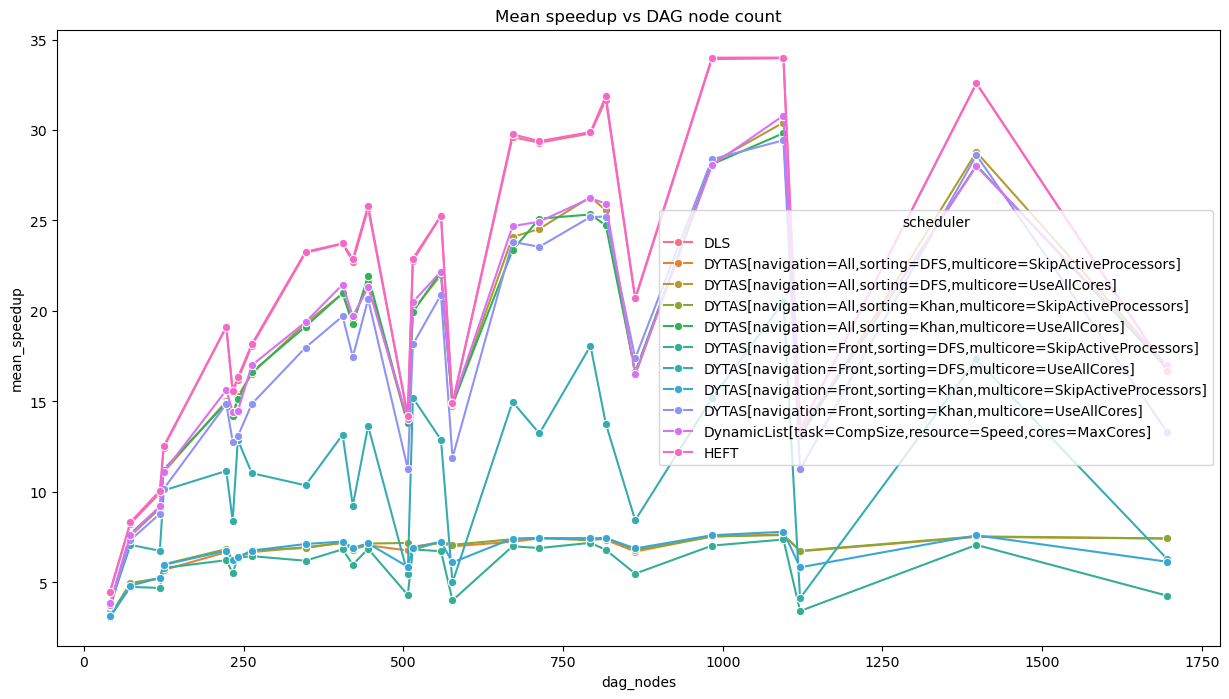

montage


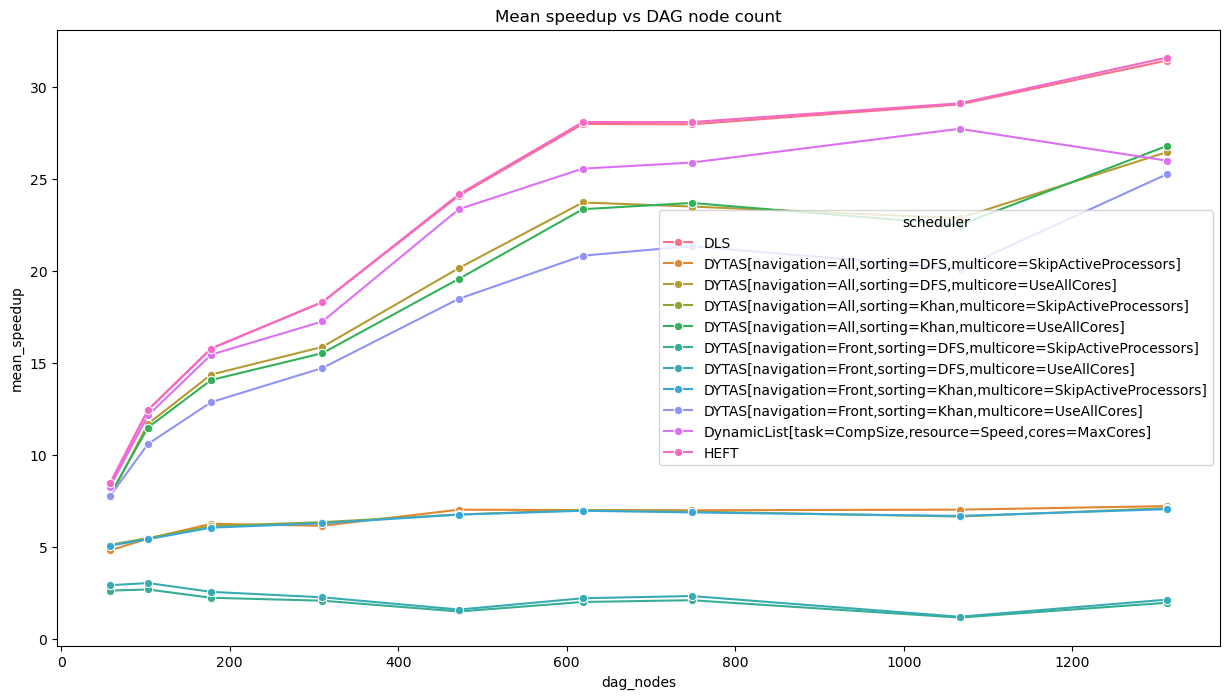

seismology


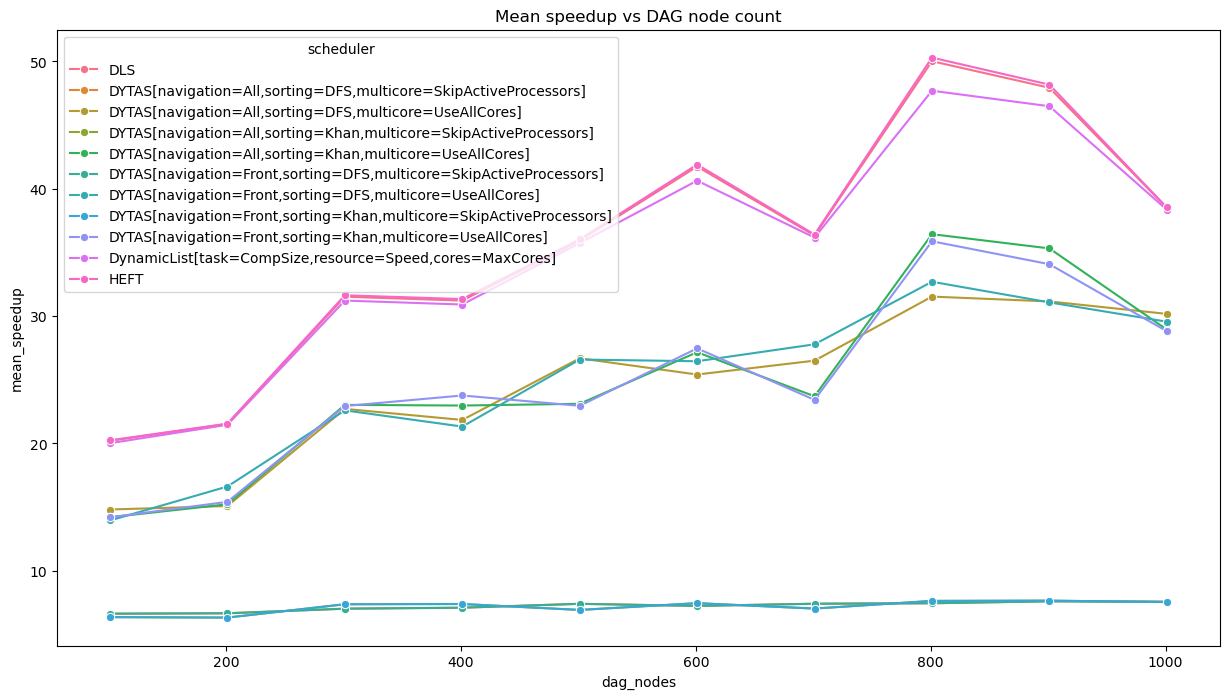

soykb


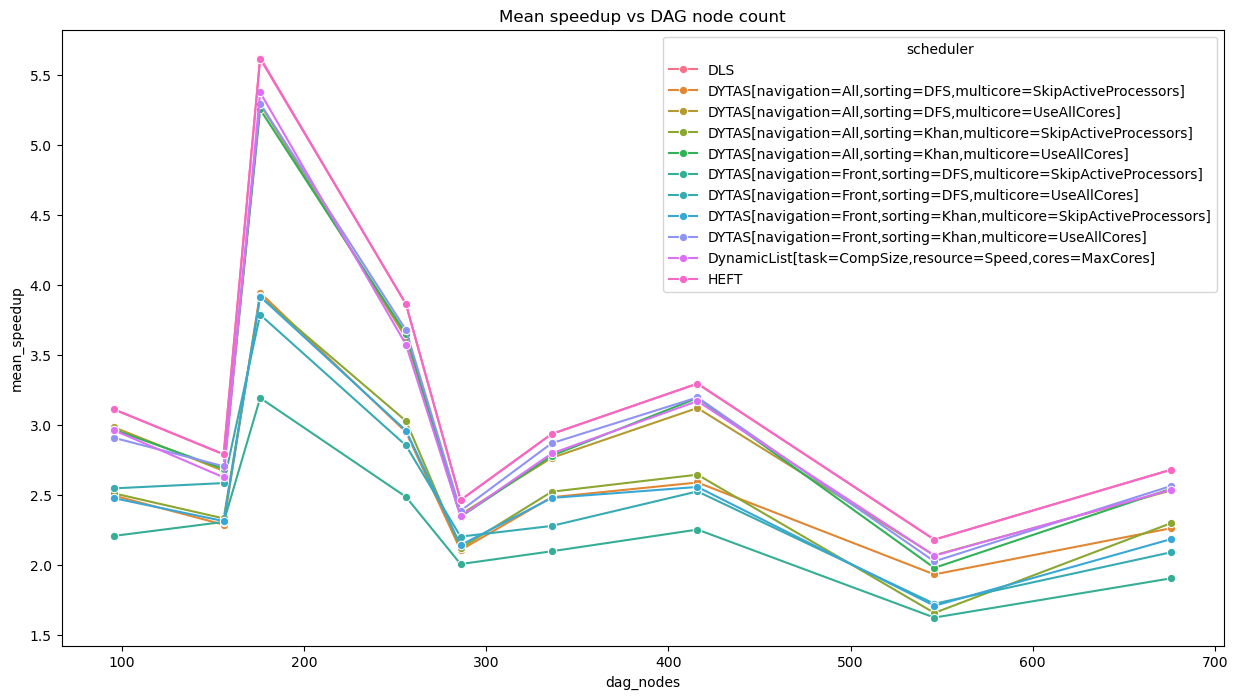

srasearch


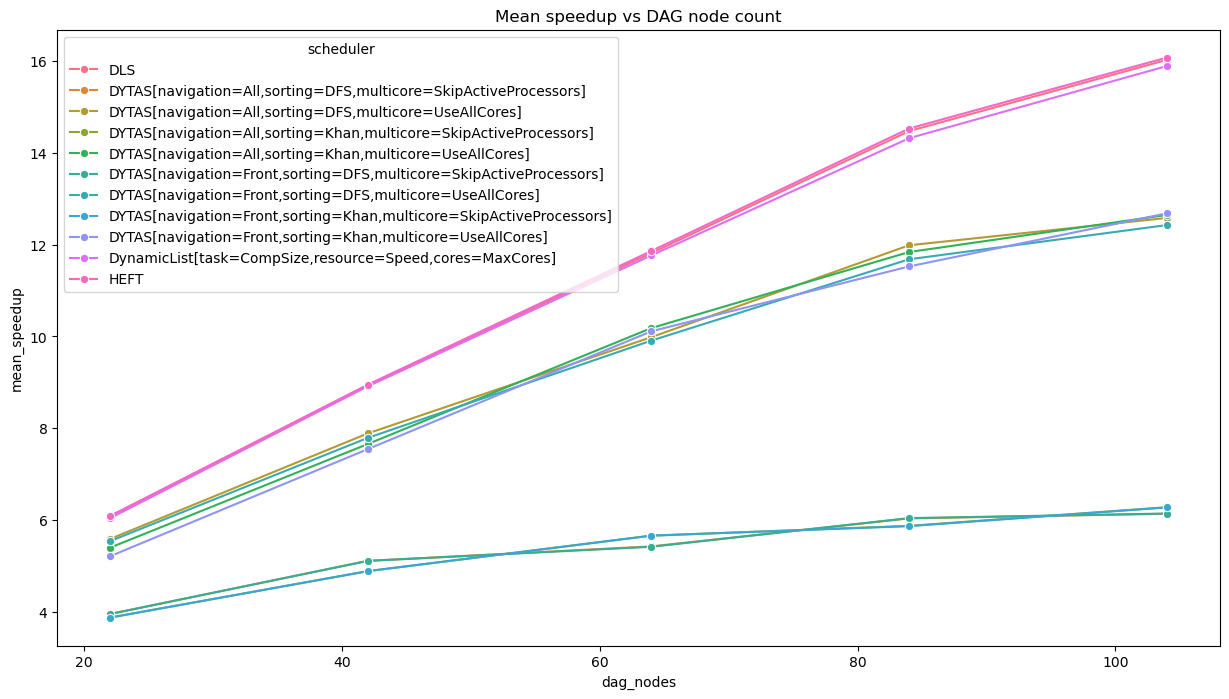

In [189]:
for workflow in df.workflow.unique():
    print(workflow)
    plot_mean_speedup(df[df.workflow == workflow])

In [191]:
df.columns

Index(['dag', 'system', 'scheduler', 'completed', 'makespan', 'exec_time',
       'run_stats.scheduling_time', 'run_stats.total_task_time',
       'run_stats.total_network_traffic', 'run_stats.total_network_time',
       'run_stats.max_used_cores', 'run_stats.max_used_memory',
       'run_stats.max_cpu_utilization', 'run_stats.max_memory_utilization',
       'run_stats.cpu_utilization', 'run_stats.memory_utilization',
       'run_stats.used_resource_count', 'run_stats.cpu_utilization_used',
       'run_stats.memory_utilization_used', 'run_stats.cpu_utilization_active',
       'run_stats.memory_utilization_active', 'run_stats.expected_makespan',
       'dag_path', 'system_path', 'dag_nodes', 'dag_edges', 'dag_density',
       'speedup', 'processor_count', 'core_count', 'efficiency_processors',
       'efficiency_cores', 'network_bandwidth', 'network_latency',
       'network_model', 'SLR', 'workflow'],
      dtype='object')

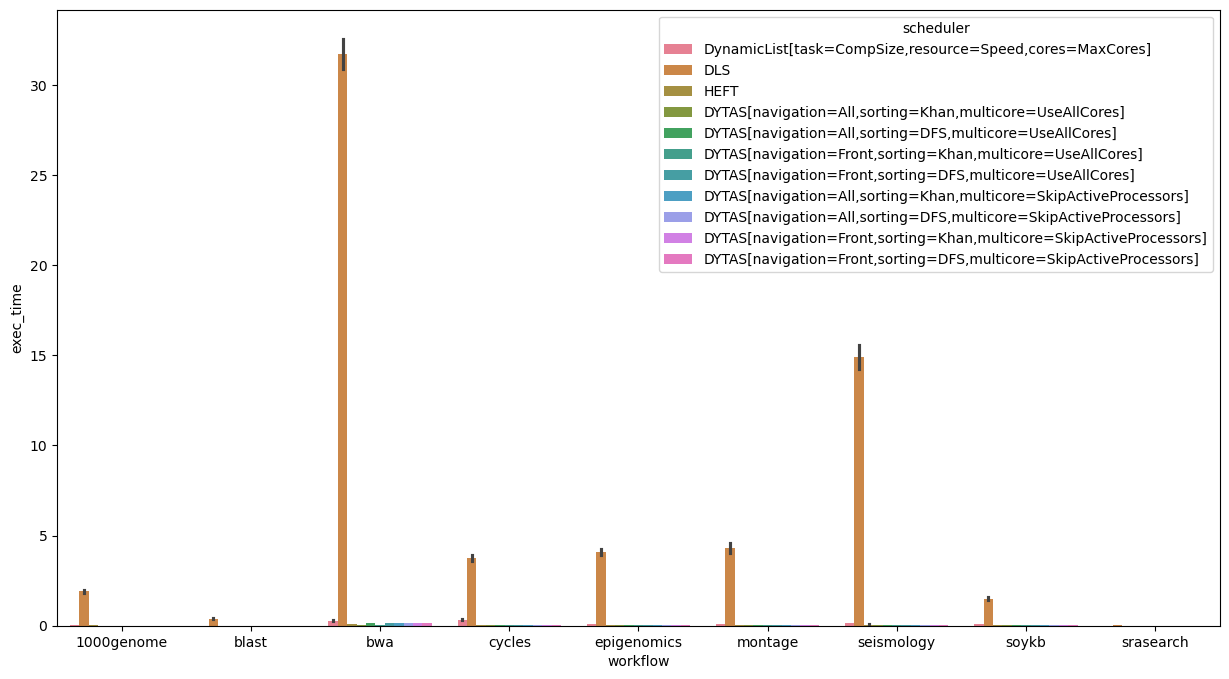

In [192]:
plt.figure(figsize=(15,8))

sns.barplot(data=df, x="workflow", y="exec_time", hue="scheduler")

plt.show()

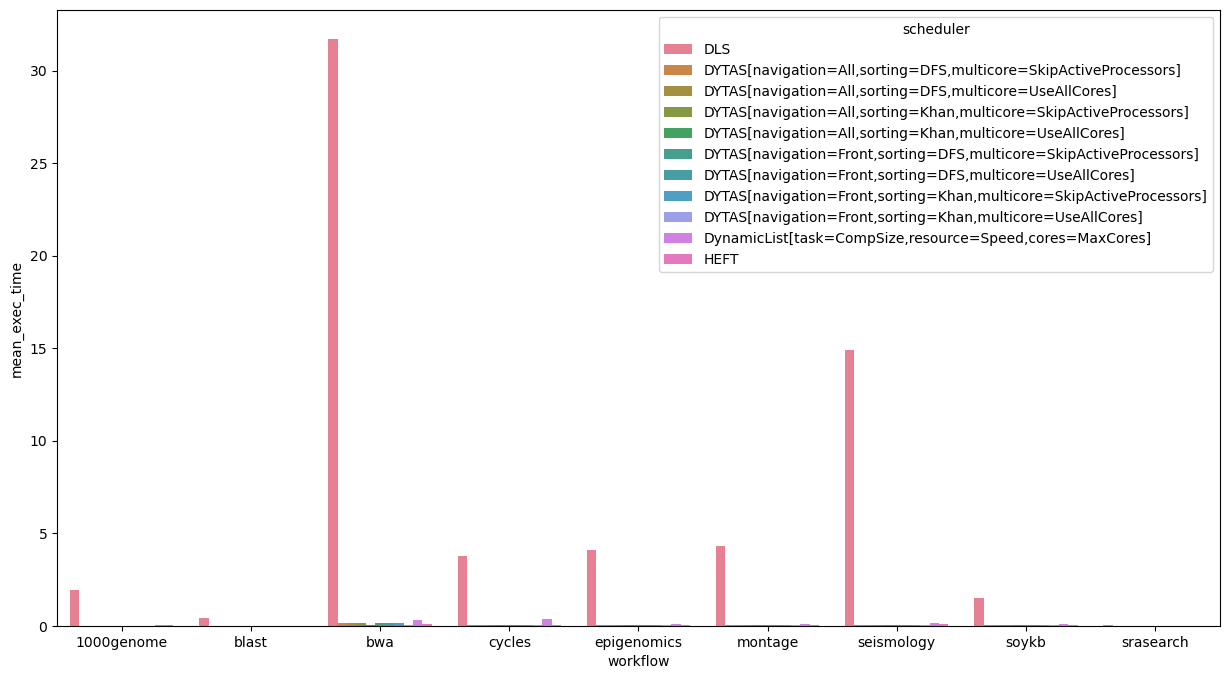

In [199]:
df_mean_workflow_exec_time = df[
    ["exec_time", "scheduler", "workflow"]
].groupby(["scheduler", "workflow"]).mean().reset_index()
df_mean_workflow_exec_time = df_mean_workflow_exec_time.rename(columns={"exec_time":"mean_exec_time"})

plt.figure(figsize=(15,8))

sns.barplot(data=df_mean_workflow_exec_time, x="workflow", y="mean_exec_time", hue="scheduler")

plt.show()

Given `DLS` is such an outlier in the above graph, and below it is easier to see all  other results with the clear assumption that `DLS` has the worst running time, followed by a large amount by `DynamicList`.

It's important to now that the below graph will depend heavily on 

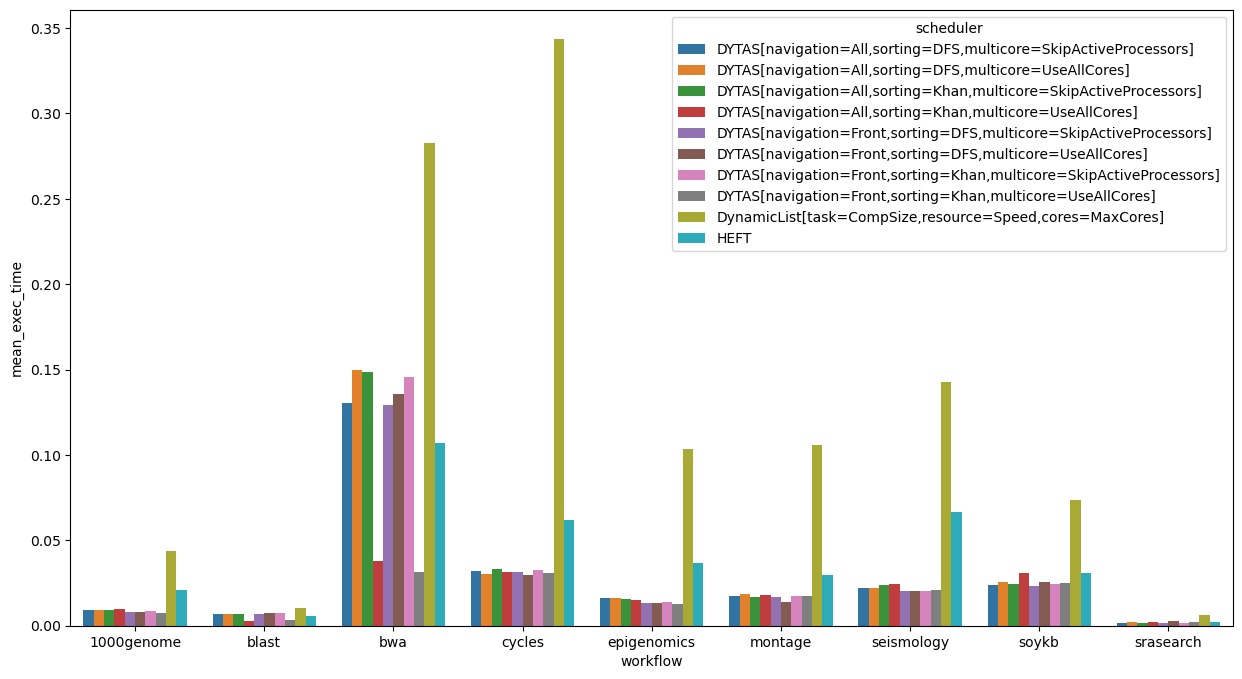

In [201]:
df_mean_workflow_exec_time = df[
    ["exec_time", "scheduler", "workflow"]
].groupby(["scheduler", "workflow"]).mean().reset_index()
df_mean_workflow_exec_time = df_mean_workflow_exec_time.rename(columns={"exec_time":"mean_exec_time"})

plt.figure(figsize=(15,8))

sns.barplot(data=df_mean_workflow_exec_time[df_mean_workflow_exec_time.scheduler != "DLS"], x="workflow", y="mean_exec_time", hue="scheduler")

plt.show()